# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

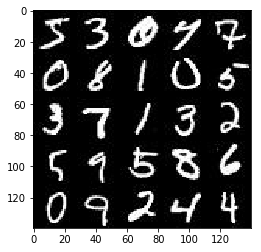

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

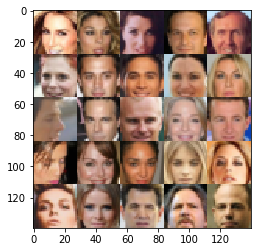

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.11.0
Default GPU Device: /device:GPU:0


In [5]:
# making sure it is using the right gpu
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13418015853972724770, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 3162085785
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 2006705766228527718
 physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"]

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    inputs_real = tf.placeholder(tf.float32, 
                                 shape=(None, image_width, image_height, image_channels), 
                                 name='input_real')
    inputs_z = tf.placeholder(tf.float32, 
                              shape=(None, z_dim), 
                              name='input_z')
    learning_rate = tf.placeholder(tf.float32, 
                                   shape=(), 
                                   name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [46]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.02 # leaky relu
    kernel_size = 5 # 5x5
    keep_prob = 0.85
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3, 
        x1 = tf.layers.conv2d(images, 32, kernel_size, strides=2, padding='same', activation=None,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, 64, kernel_size, strides=2, padding='same', activation=None)
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 7x7x64
        
        x3 = tf.layers.conv2d(x2, 128, kernel_size, strides=2, padding='same', activation=None)
        x3 = tf.layers.batch_normalization(x2, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 4x4x128
        
        # flatten
        flat = tf.reshape(x3, (-1, 4*4*128))
        logits = tf.layers.dense(flat, 1, activation=None)
        out = tf.sigmoid(logits)
    
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [53]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    alpha = 0.02 # leaky relu
    kernel_size = 5 # 5x5
    keep_prob = 0.85
        
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # first dense layer
        x0 = tf.layers.dense(z, 7*7*128)
        
        # reshape to start convolutional
        x1 = tf.reshape(x0, (-1, 7, 7, 128))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        x1 = tf.nn.dropout(x1, keep_prob)
        # 7x7x128
        
        x2 = tf.layers.conv2d_transpose(x1, 64, kernel_size, strides=2, padding='same', activation=None,
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.nn.dropout(x2, keep_prob)
        # 14x14x64
        
        x3 = tf.layers.conv2d_transpose(x2, 32, kernel_size, strides=2, padding='same', activation=None)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.nn.dropout(x3, keep_prob)
        # 28x28x32
        
        # output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, kernel_size, strides=1, padding='same', activation=None)
        # 28x28x3
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # generator
    g_model = generator(input_z, out_channel_dim)
    
    # discriminator
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # discriminator with real expects 1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    # discriminator with fake expects 0
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    # generator expects discriminator with fake 1
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    # filter weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [23]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [56]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)   
    
    steps = 0
    step_print = 10 # print loss
    step_plot = 100 # plot output
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # images are range -.5:.5, scales images to -1: 1
                batch_images *= 2
                
                # generator noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # run optimizers
                _ = sess.run(d_opt, feed_dict={input_z: batch_z,
                                               input_real: batch_images, 
                                               lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                               input_real: batch_images, 
                                               lr: learning_rate})
                
                # visual progress
                if steps % step_print == 0:
                    # get the losses
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print(f"Epoch {epoch_i+1}/{epoch_count} steps {steps}, ",
                          "Discriminator Loss: {:.4f}, ".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % step_plot == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
    
        # final plot
        print('Final Plot')
        show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 steps 10,  Discriminator Loss: 1.7650,  Generator Loss: 0.6406
Epoch 1/2 steps 20,  Discriminator Loss: 1.5261,  Generator Loss: 0.8557
Epoch 1/2 steps 30,  Discriminator Loss: 1.5361,  Generator Loss: 0.9716
Epoch 1/2 steps 40,  Discriminator Loss: 1.5061,  Generator Loss: 0.9410
Epoch 1/2 steps 50,  Discriminator Loss: 1.2601,  Generator Loss: 0.8946
Epoch 1/2 steps 60,  Discriminator Loss: 1.3091,  Generator Loss: 1.1312
Epoch 1/2 steps 70,  Discriminator Loss: 1.0886,  Generator Loss: 1.0846
Epoch 1/2 steps 80,  Discriminator Loss: 1.0520,  Generator Loss: 1.3288
Epoch 1/2 steps 90,  Discriminator Loss: 0.9685,  Generator Loss: 1.5521
Epoch 1/2 steps 100,  Discriminator Loss: 0.9576,  Generator Loss: 1.3402


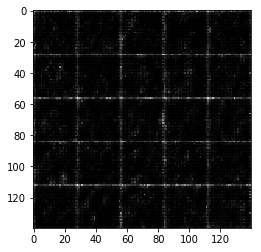

Epoch 1/2 steps 110,  Discriminator Loss: 1.0599,  Generator Loss: 1.2663
Epoch 1/2 steps 120,  Discriminator Loss: 1.4359,  Generator Loss: 0.9145
Epoch 1/2 steps 130,  Discriminator Loss: 1.3005,  Generator Loss: 0.9777
Epoch 1/2 steps 140,  Discriminator Loss: 1.2542,  Generator Loss: 1.2000
Epoch 1/2 steps 150,  Discriminator Loss: 1.1714,  Generator Loss: 1.2236
Epoch 1/2 steps 160,  Discriminator Loss: 1.1543,  Generator Loss: 1.2112
Epoch 1/2 steps 170,  Discriminator Loss: 1.2125,  Generator Loss: 1.1546
Epoch 1/2 steps 180,  Discriminator Loss: 1.1860,  Generator Loss: 1.2432
Epoch 1/2 steps 190,  Discriminator Loss: 1.2029,  Generator Loss: 1.0290
Epoch 1/2 steps 200,  Discriminator Loss: 1.1993,  Generator Loss: 1.5195


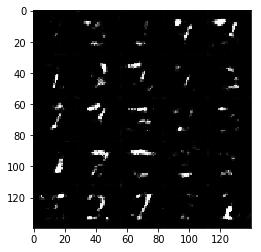

Epoch 1/2 steps 210,  Discriminator Loss: 1.2805,  Generator Loss: 1.1586
Epoch 1/2 steps 220,  Discriminator Loss: 1.1565,  Generator Loss: 1.1410
Epoch 1/2 steps 230,  Discriminator Loss: 1.1732,  Generator Loss: 1.1755
Epoch 1/2 steps 240,  Discriminator Loss: 1.2614,  Generator Loss: 1.1729
Epoch 1/2 steps 250,  Discriminator Loss: 1.2657,  Generator Loss: 0.7851
Epoch 1/2 steps 260,  Discriminator Loss: 1.0497,  Generator Loss: 1.1693
Epoch 1/2 steps 270,  Discriminator Loss: 1.3882,  Generator Loss: 0.8494
Epoch 1/2 steps 280,  Discriminator Loss: 1.2654,  Generator Loss: 1.3216
Epoch 1/2 steps 290,  Discriminator Loss: 1.3152,  Generator Loss: 0.8341
Epoch 1/2 steps 300,  Discriminator Loss: 1.3633,  Generator Loss: 0.9420


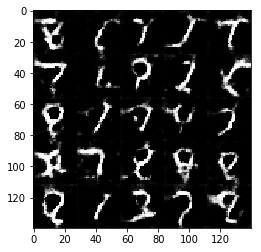

Epoch 1/2 steps 310,  Discriminator Loss: 1.3271,  Generator Loss: 1.0816
Epoch 1/2 steps 320,  Discriminator Loss: 1.3312,  Generator Loss: 1.2372
Epoch 1/2 steps 330,  Discriminator Loss: 1.2718,  Generator Loss: 0.9872
Epoch 1/2 steps 340,  Discriminator Loss: 1.3108,  Generator Loss: 1.1079
Epoch 1/2 steps 350,  Discriminator Loss: 1.2181,  Generator Loss: 1.0409
Epoch 1/2 steps 360,  Discriminator Loss: 1.3297,  Generator Loss: 1.1736
Epoch 1/2 steps 370,  Discriminator Loss: 1.2909,  Generator Loss: 1.1390
Epoch 1/2 steps 380,  Discriminator Loss: 1.3857,  Generator Loss: 1.1862
Epoch 1/2 steps 390,  Discriminator Loss: 1.3626,  Generator Loss: 0.8868
Epoch 1/2 steps 400,  Discriminator Loss: 1.3575,  Generator Loss: 1.0123


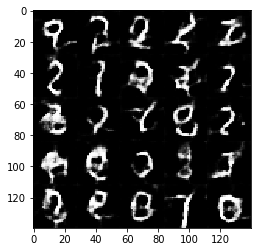

Epoch 1/2 steps 410,  Discriminator Loss: 1.2727,  Generator Loss: 0.9210
Epoch 1/2 steps 420,  Discriminator Loss: 1.3605,  Generator Loss: 0.8920
Epoch 1/2 steps 430,  Discriminator Loss: 1.3154,  Generator Loss: 0.8982
Epoch 1/2 steps 440,  Discriminator Loss: 1.2866,  Generator Loss: 0.9704
Epoch 1/2 steps 450,  Discriminator Loss: 1.3321,  Generator Loss: 0.9646
Epoch 1/2 steps 460,  Discriminator Loss: 1.4082,  Generator Loss: 1.0573
Epoch 1/2 steps 470,  Discriminator Loss: 1.3651,  Generator Loss: 0.9686
Epoch 1/2 steps 480,  Discriminator Loss: 1.3308,  Generator Loss: 0.8482
Epoch 1/2 steps 490,  Discriminator Loss: 1.3422,  Generator Loss: 1.0273
Epoch 1/2 steps 500,  Discriminator Loss: 1.3513,  Generator Loss: 0.9855


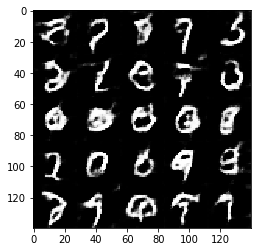

Epoch 1/2 steps 510,  Discriminator Loss: 1.2651,  Generator Loss: 0.9739
Epoch 1/2 steps 520,  Discriminator Loss: 1.4820,  Generator Loss: 0.9035
Epoch 1/2 steps 530,  Discriminator Loss: 1.3155,  Generator Loss: 0.9686
Epoch 1/2 steps 540,  Discriminator Loss: 1.3370,  Generator Loss: 1.0033
Epoch 1/2 steps 550,  Discriminator Loss: 1.3847,  Generator Loss: 0.9584
Epoch 1/2 steps 560,  Discriminator Loss: 1.2802,  Generator Loss: 0.9057
Epoch 1/2 steps 570,  Discriminator Loss: 1.3829,  Generator Loss: 0.9943
Epoch 1/2 steps 580,  Discriminator Loss: 1.3768,  Generator Loss: 0.8655
Epoch 1/2 steps 590,  Discriminator Loss: 1.3588,  Generator Loss: 0.9672
Epoch 1/2 steps 600,  Discriminator Loss: 1.3585,  Generator Loss: 1.0476


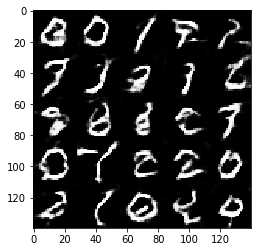

Epoch 1/2 steps 610,  Discriminator Loss: 1.3290,  Generator Loss: 0.9083
Epoch 1/2 steps 620,  Discriminator Loss: 1.3172,  Generator Loss: 0.9690
Epoch 1/2 steps 630,  Discriminator Loss: 1.2968,  Generator Loss: 0.9301
Epoch 1/2 steps 640,  Discriminator Loss: 1.3214,  Generator Loss: 0.9372
Epoch 1/2 steps 650,  Discriminator Loss: 1.3388,  Generator Loss: 0.9376
Epoch 1/2 steps 660,  Discriminator Loss: 1.3736,  Generator Loss: 0.9518
Epoch 1/2 steps 670,  Discriminator Loss: 1.3381,  Generator Loss: 0.8680
Epoch 1/2 steps 680,  Discriminator Loss: 1.4045,  Generator Loss: 0.8497
Epoch 1/2 steps 690,  Discriminator Loss: 1.3040,  Generator Loss: 0.9920
Epoch 1/2 steps 700,  Discriminator Loss: 1.2775,  Generator Loss: 0.9967


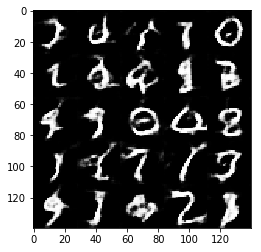

Epoch 1/2 steps 710,  Discriminator Loss: 1.2885,  Generator Loss: 0.9750
Epoch 1/2 steps 720,  Discriminator Loss: 1.3509,  Generator Loss: 0.9183
Epoch 1/2 steps 730,  Discriminator Loss: 1.2962,  Generator Loss: 0.9172
Epoch 1/2 steps 740,  Discriminator Loss: 1.3278,  Generator Loss: 0.9000
Epoch 1/2 steps 750,  Discriminator Loss: 1.2422,  Generator Loss: 0.8382
Epoch 1/2 steps 760,  Discriminator Loss: 1.2571,  Generator Loss: 0.9993
Epoch 1/2 steps 770,  Discriminator Loss: 1.3139,  Generator Loss: 0.9362
Epoch 1/2 steps 780,  Discriminator Loss: 1.3253,  Generator Loss: 0.9342
Epoch 1/2 steps 790,  Discriminator Loss: 1.3190,  Generator Loss: 0.9708
Epoch 1/2 steps 800,  Discriminator Loss: 1.2929,  Generator Loss: 0.9111


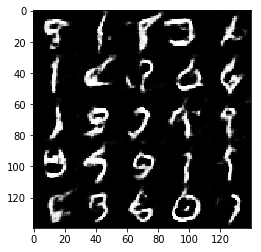

Epoch 1/2 steps 810,  Discriminator Loss: 1.2672,  Generator Loss: 0.9270
Epoch 1/2 steps 820,  Discriminator Loss: 1.3155,  Generator Loss: 0.9974
Epoch 1/2 steps 830,  Discriminator Loss: 1.2958,  Generator Loss: 0.9032
Epoch 1/2 steps 840,  Discriminator Loss: 1.3375,  Generator Loss: 0.9628
Epoch 1/2 steps 850,  Discriminator Loss: 1.3961,  Generator Loss: 1.0149
Epoch 1/2 steps 860,  Discriminator Loss: 1.3628,  Generator Loss: 1.0377
Epoch 1/2 steps 870,  Discriminator Loss: 1.3331,  Generator Loss: 0.8868
Epoch 1/2 steps 880,  Discriminator Loss: 1.3381,  Generator Loss: 0.9590
Epoch 1/2 steps 890,  Discriminator Loss: 1.3443,  Generator Loss: 0.8521
Epoch 1/2 steps 900,  Discriminator Loss: 1.2971,  Generator Loss: 0.8601


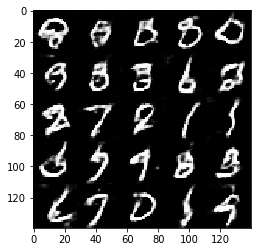

Epoch 1/2 steps 910,  Discriminator Loss: 1.3217,  Generator Loss: 0.8569
Epoch 1/2 steps 920,  Discriminator Loss: 1.3529,  Generator Loss: 0.9971
Epoch 1/2 steps 930,  Discriminator Loss: 1.3297,  Generator Loss: 0.9096
Epoch 2/2 steps 940,  Discriminator Loss: 1.3077,  Generator Loss: 0.9228
Epoch 2/2 steps 950,  Discriminator Loss: 1.2830,  Generator Loss: 0.9118
Epoch 2/2 steps 960,  Discriminator Loss: 1.2949,  Generator Loss: 0.9468
Epoch 2/2 steps 970,  Discriminator Loss: 1.3186,  Generator Loss: 0.9149
Epoch 2/2 steps 980,  Discriminator Loss: 1.3174,  Generator Loss: 0.9681
Epoch 2/2 steps 990,  Discriminator Loss: 1.3280,  Generator Loss: 0.9992
Epoch 2/2 steps 1000,  Discriminator Loss: 1.3114,  Generator Loss: 0.9115


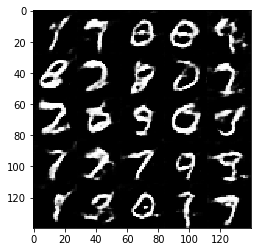

Epoch 2/2 steps 1010,  Discriminator Loss: 1.3511,  Generator Loss: 0.9149
Epoch 2/2 steps 1020,  Discriminator Loss: 1.3534,  Generator Loss: 0.9152
Epoch 2/2 steps 1030,  Discriminator Loss: 1.3098,  Generator Loss: 1.0818
Epoch 2/2 steps 1040,  Discriminator Loss: 1.3561,  Generator Loss: 0.8943
Epoch 2/2 steps 1050,  Discriminator Loss: 1.3224,  Generator Loss: 0.9146
Epoch 2/2 steps 1060,  Discriminator Loss: 1.3726,  Generator Loss: 0.9055
Epoch 2/2 steps 1070,  Discriminator Loss: 1.2958,  Generator Loss: 0.9352
Epoch 2/2 steps 1080,  Discriminator Loss: 1.3463,  Generator Loss: 0.9918
Epoch 2/2 steps 1090,  Discriminator Loss: 1.3303,  Generator Loss: 0.8774
Epoch 2/2 steps 1100,  Discriminator Loss: 1.2808,  Generator Loss: 1.0721


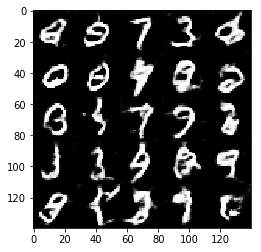

Epoch 2/2 steps 1110,  Discriminator Loss: 1.2863,  Generator Loss: 0.9462
Epoch 2/2 steps 1120,  Discriminator Loss: 1.3353,  Generator Loss: 1.0054
Epoch 2/2 steps 1130,  Discriminator Loss: 1.3039,  Generator Loss: 1.0363
Epoch 2/2 steps 1140,  Discriminator Loss: 1.2615,  Generator Loss: 0.9407
Epoch 2/2 steps 1150,  Discriminator Loss: 1.2888,  Generator Loss: 0.9243
Epoch 2/2 steps 1160,  Discriminator Loss: 1.3526,  Generator Loss: 0.8956
Epoch 2/2 steps 1170,  Discriminator Loss: 1.2697,  Generator Loss: 0.9877
Epoch 2/2 steps 1180,  Discriminator Loss: 1.3274,  Generator Loss: 0.8961
Epoch 2/2 steps 1190,  Discriminator Loss: 1.2935,  Generator Loss: 0.9620
Epoch 2/2 steps 1200,  Discriminator Loss: 1.2414,  Generator Loss: 0.8577


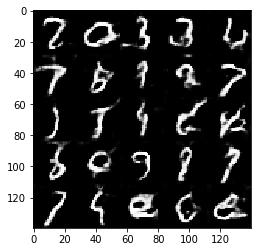

Epoch 2/2 steps 1210,  Discriminator Loss: 1.3205,  Generator Loss: 0.9579
Epoch 2/2 steps 1220,  Discriminator Loss: 1.2520,  Generator Loss: 0.9761
Epoch 2/2 steps 1230,  Discriminator Loss: 1.2503,  Generator Loss: 0.8870
Epoch 2/2 steps 1240,  Discriminator Loss: 1.2582,  Generator Loss: 0.9629
Epoch 2/2 steps 1250,  Discriminator Loss: 1.3406,  Generator Loss: 0.8919
Epoch 2/2 steps 1260,  Discriminator Loss: 1.3325,  Generator Loss: 0.9527
Epoch 2/2 steps 1270,  Discriminator Loss: 1.2914,  Generator Loss: 0.9190
Epoch 2/2 steps 1280,  Discriminator Loss: 1.3651,  Generator Loss: 0.9389
Epoch 2/2 steps 1290,  Discriminator Loss: 1.2833,  Generator Loss: 1.1358
Epoch 2/2 steps 1300,  Discriminator Loss: 1.3574,  Generator Loss: 0.9299


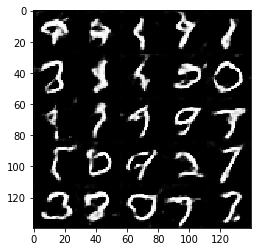

Epoch 2/2 steps 1310,  Discriminator Loss: 1.2922,  Generator Loss: 0.9883
Epoch 2/2 steps 1320,  Discriminator Loss: 1.3126,  Generator Loss: 0.9044
Epoch 2/2 steps 1330,  Discriminator Loss: 1.3367,  Generator Loss: 0.9283
Epoch 2/2 steps 1340,  Discriminator Loss: 1.3338,  Generator Loss: 0.9437
Epoch 2/2 steps 1350,  Discriminator Loss: 1.3154,  Generator Loss: 0.9252
Epoch 2/2 steps 1360,  Discriminator Loss: 1.3227,  Generator Loss: 0.9336
Epoch 2/2 steps 1370,  Discriminator Loss: 1.3377,  Generator Loss: 1.0445
Epoch 2/2 steps 1380,  Discriminator Loss: 1.3521,  Generator Loss: 0.9937
Epoch 2/2 steps 1390,  Discriminator Loss: 1.2959,  Generator Loss: 0.9808
Epoch 2/2 steps 1400,  Discriminator Loss: 1.3130,  Generator Loss: 0.9523


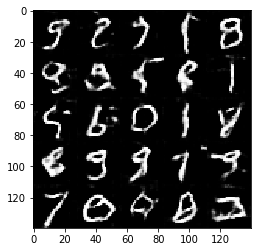

Epoch 2/2 steps 1410,  Discriminator Loss: 1.2653,  Generator Loss: 0.9387
Epoch 2/2 steps 1420,  Discriminator Loss: 1.2960,  Generator Loss: 0.9341
Epoch 2/2 steps 1430,  Discriminator Loss: 1.3330,  Generator Loss: 0.8437
Epoch 2/2 steps 1440,  Discriminator Loss: 1.2615,  Generator Loss: 0.8586
Epoch 2/2 steps 1450,  Discriminator Loss: 1.3173,  Generator Loss: 0.8283
Epoch 2/2 steps 1460,  Discriminator Loss: 1.2451,  Generator Loss: 0.9608
Epoch 2/2 steps 1470,  Discriminator Loss: 1.3097,  Generator Loss: 1.1077
Epoch 2/2 steps 1480,  Discriminator Loss: 1.2568,  Generator Loss: 0.8299
Epoch 2/2 steps 1490,  Discriminator Loss: 1.2944,  Generator Loss: 0.9174
Epoch 2/2 steps 1500,  Discriminator Loss: 1.2507,  Generator Loss: 0.8399


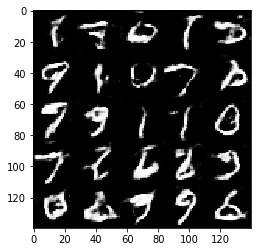

Epoch 2/2 steps 1510,  Discriminator Loss: 1.2637,  Generator Loss: 0.9681
Epoch 2/2 steps 1520,  Discriminator Loss: 1.2477,  Generator Loss: 1.0027
Epoch 2/2 steps 1530,  Discriminator Loss: 1.3165,  Generator Loss: 0.9241
Epoch 2/2 steps 1540,  Discriminator Loss: 1.2891,  Generator Loss: 0.9901
Epoch 2/2 steps 1550,  Discriminator Loss: 1.2382,  Generator Loss: 1.0115
Epoch 2/2 steps 1560,  Discriminator Loss: 1.2728,  Generator Loss: 1.0229
Epoch 2/2 steps 1570,  Discriminator Loss: 1.2813,  Generator Loss: 0.9322
Epoch 2/2 steps 1580,  Discriminator Loss: 1.2604,  Generator Loss: 1.1047
Epoch 2/2 steps 1590,  Discriminator Loss: 1.2922,  Generator Loss: 1.0141
Epoch 2/2 steps 1600,  Discriminator Loss: 1.1953,  Generator Loss: 1.1388


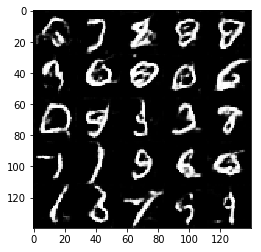

Epoch 2/2 steps 1610,  Discriminator Loss: 1.2989,  Generator Loss: 0.9674
Epoch 2/2 steps 1620,  Discriminator Loss: 1.2634,  Generator Loss: 0.9239
Epoch 2/2 steps 1630,  Discriminator Loss: 1.3474,  Generator Loss: 0.9949
Epoch 2/2 steps 1640,  Discriminator Loss: 1.3127,  Generator Loss: 0.9525
Epoch 2/2 steps 1650,  Discriminator Loss: 1.3452,  Generator Loss: 0.9410
Epoch 2/2 steps 1660,  Discriminator Loss: 1.2845,  Generator Loss: 0.9653
Epoch 2/2 steps 1670,  Discriminator Loss: 1.2449,  Generator Loss: 0.9787
Epoch 2/2 steps 1680,  Discriminator Loss: 1.2574,  Generator Loss: 1.0918
Epoch 2/2 steps 1690,  Discriminator Loss: 1.3128,  Generator Loss: 0.9266
Epoch 2/2 steps 1700,  Discriminator Loss: 1.3262,  Generator Loss: 0.8611


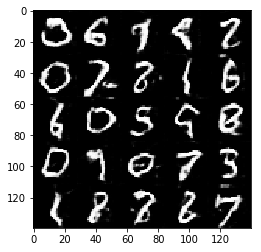

Epoch 2/2 steps 1710,  Discriminator Loss: 1.3414,  Generator Loss: 1.0069
Epoch 2/2 steps 1720,  Discriminator Loss: 1.3313,  Generator Loss: 0.8657
Epoch 2/2 steps 1730,  Discriminator Loss: 1.3146,  Generator Loss: 0.8787
Epoch 2/2 steps 1740,  Discriminator Loss: 1.2792,  Generator Loss: 0.9809
Epoch 2/2 steps 1750,  Discriminator Loss: 1.2723,  Generator Loss: 0.9840
Epoch 2/2 steps 1760,  Discriminator Loss: 1.3085,  Generator Loss: 1.2575
Epoch 2/2 steps 1770,  Discriminator Loss: 1.3148,  Generator Loss: 0.9758
Epoch 2/2 steps 1780,  Discriminator Loss: 1.2646,  Generator Loss: 0.9233
Epoch 2/2 steps 1790,  Discriminator Loss: 1.2697,  Generator Loss: 1.0777
Epoch 2/2 steps 1800,  Discriminator Loss: 1.2157,  Generator Loss: 0.8632


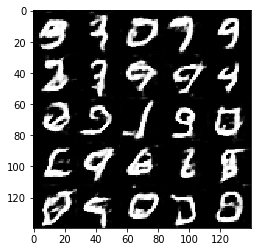

Epoch 2/2 steps 1810,  Discriminator Loss: 1.3588,  Generator Loss: 0.9489
Epoch 2/2 steps 1820,  Discriminator Loss: 1.2807,  Generator Loss: 0.9060
Epoch 2/2 steps 1830,  Discriminator Loss: 1.2803,  Generator Loss: 0.9064
Epoch 2/2 steps 1840,  Discriminator Loss: 1.2992,  Generator Loss: 0.9297
Epoch 2/2 steps 1850,  Discriminator Loss: 1.2824,  Generator Loss: 1.0978
Epoch 2/2 steps 1860,  Discriminator Loss: 1.3612,  Generator Loss: 0.9170
Epoch 2/2 steps 1870,  Discriminator Loss: 1.3091,  Generator Loss: 0.9894
Final Plot


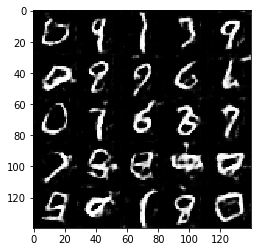

In [51]:
batch_size = 64
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 steps 10,  Discriminator Loss: 1.9197,  Generator Loss: 0.7725
Epoch 1/1 steps 20,  Discriminator Loss: 1.6991,  Generator Loss: 0.9823
Epoch 1/1 steps 30,  Discriminator Loss: 1.7066,  Generator Loss: 0.8292
Epoch 1/1 steps 40,  Discriminator Loss: 1.5613,  Generator Loss: 1.0664
Epoch 1/1 steps 50,  Discriminator Loss: 1.6361,  Generator Loss: 0.7988
Epoch 1/1 steps 60,  Discriminator Loss: 1.3873,  Generator Loss: 0.9026
Epoch 1/1 steps 70,  Discriminator Loss: 1.4958,  Generator Loss: 0.9632
Epoch 1/1 steps 80,  Discriminator Loss: 1.4356,  Generator Loss: 1.0003
Epoch 1/1 steps 90,  Discriminator Loss: 1.2103,  Generator Loss: 0.9899
Epoch 1/1 steps 100,  Discriminator Loss: 1.1854,  Generator Loss: 1.2682


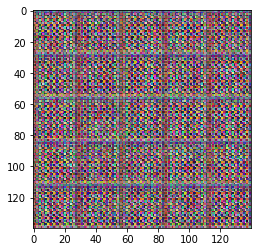

Epoch 1/1 steps 110,  Discriminator Loss: 1.2470,  Generator Loss: 1.3360
Epoch 1/1 steps 120,  Discriminator Loss: 1.1849,  Generator Loss: 1.3203
Epoch 1/1 steps 130,  Discriminator Loss: 1.1091,  Generator Loss: 1.2759
Epoch 1/1 steps 140,  Discriminator Loss: 1.1632,  Generator Loss: 1.0496
Epoch 1/1 steps 150,  Discriminator Loss: 1.2354,  Generator Loss: 1.1499
Epoch 1/1 steps 160,  Discriminator Loss: 1.1117,  Generator Loss: 1.1379
Epoch 1/1 steps 170,  Discriminator Loss: 1.1189,  Generator Loss: 1.2033
Epoch 1/1 steps 180,  Discriminator Loss: 1.0263,  Generator Loss: 1.3169
Epoch 1/1 steps 190,  Discriminator Loss: 0.9541,  Generator Loss: 1.3592
Epoch 1/1 steps 200,  Discriminator Loss: 1.1007,  Generator Loss: 1.2950


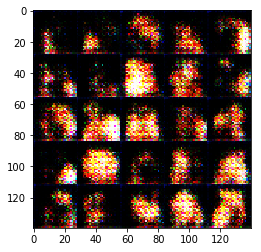

Epoch 1/1 steps 210,  Discriminator Loss: 0.9868,  Generator Loss: 1.5651
Epoch 1/1 steps 220,  Discriminator Loss: 0.7655,  Generator Loss: 1.6365
Epoch 1/1 steps 230,  Discriminator Loss: 1.0727,  Generator Loss: 1.2981
Epoch 1/1 steps 240,  Discriminator Loss: 0.7995,  Generator Loss: 1.4582
Epoch 1/1 steps 250,  Discriminator Loss: 0.6574,  Generator Loss: 1.6581
Epoch 1/1 steps 260,  Discriminator Loss: 0.6237,  Generator Loss: 2.2523
Epoch 1/1 steps 270,  Discriminator Loss: 0.6266,  Generator Loss: 2.0290
Epoch 1/1 steps 280,  Discriminator Loss: 0.6249,  Generator Loss: 2.3160
Epoch 1/1 steps 290,  Discriminator Loss: 0.5574,  Generator Loss: 2.4663
Epoch 1/1 steps 300,  Discriminator Loss: 0.6034,  Generator Loss: 2.4253


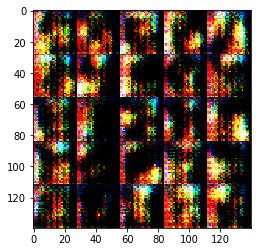

Epoch 1/1 steps 310,  Discriminator Loss: 0.5774,  Generator Loss: 2.2768
Epoch 1/1 steps 320,  Discriminator Loss: 0.5369,  Generator Loss: 2.7116
Epoch 1/1 steps 330,  Discriminator Loss: 0.5781,  Generator Loss: 2.6681
Epoch 1/1 steps 340,  Discriminator Loss: 0.5811,  Generator Loss: 2.6812
Epoch 1/1 steps 350,  Discriminator Loss: 0.5028,  Generator Loss: 3.1320
Epoch 1/1 steps 360,  Discriminator Loss: 0.4775,  Generator Loss: 2.9994
Epoch 1/1 steps 370,  Discriminator Loss: 0.5007,  Generator Loss: 2.6535
Epoch 1/1 steps 380,  Discriminator Loss: 0.5087,  Generator Loss: 3.0904
Epoch 1/1 steps 390,  Discriminator Loss: 0.6241,  Generator Loss: 2.5343
Epoch 1/1 steps 400,  Discriminator Loss: 0.4677,  Generator Loss: 3.1962


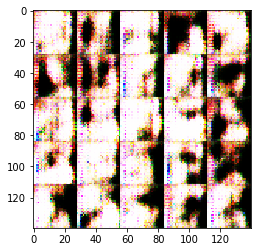

Epoch 1/1 steps 410,  Discriminator Loss: 0.4717,  Generator Loss: 3.0440
Epoch 1/1 steps 420,  Discriminator Loss: 0.4784,  Generator Loss: 3.5156
Epoch 1/1 steps 430,  Discriminator Loss: 0.4726,  Generator Loss: 3.2481
Epoch 1/1 steps 440,  Discriminator Loss: 0.7288,  Generator Loss: 3.4192
Epoch 1/1 steps 450,  Discriminator Loss: 0.4888,  Generator Loss: 3.2518
Epoch 1/1 steps 460,  Discriminator Loss: 0.5105,  Generator Loss: 3.3432
Epoch 1/1 steps 470,  Discriminator Loss: 0.4800,  Generator Loss: 2.9820
Epoch 1/1 steps 480,  Discriminator Loss: 0.5435,  Generator Loss: 3.6585
Epoch 1/1 steps 490,  Discriminator Loss: 0.5745,  Generator Loss: 2.6303
Epoch 1/1 steps 500,  Discriminator Loss: 0.6977,  Generator Loss: 2.4255


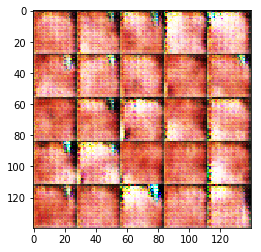

Epoch 1/1 steps 510,  Discriminator Loss: 1.6754,  Generator Loss: 3.2306
Epoch 1/1 steps 520,  Discriminator Loss: 0.8857,  Generator Loss: 1.5749
Epoch 1/1 steps 530,  Discriminator Loss: 0.9842,  Generator Loss: 1.1962
Epoch 1/1 steps 540,  Discriminator Loss: 1.3579,  Generator Loss: 1.0864
Epoch 1/1 steps 550,  Discriminator Loss: 1.1739,  Generator Loss: 1.0901
Epoch 1/1 steps 560,  Discriminator Loss: 1.4599,  Generator Loss: 1.3390
Epoch 1/1 steps 570,  Discriminator Loss: 1.2363,  Generator Loss: 0.9039
Epoch 1/1 steps 580,  Discriminator Loss: 1.3136,  Generator Loss: 1.1200
Epoch 1/1 steps 590,  Discriminator Loss: 1.3255,  Generator Loss: 1.2934
Epoch 1/1 steps 600,  Discriminator Loss: 1.4009,  Generator Loss: 0.9775


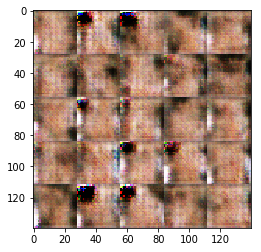

Epoch 1/1 steps 610,  Discriminator Loss: 1.3838,  Generator Loss: 0.9536
Epoch 1/1 steps 620,  Discriminator Loss: 1.4141,  Generator Loss: 1.1537
Epoch 1/1 steps 630,  Discriminator Loss: 1.5064,  Generator Loss: 0.9486
Epoch 1/1 steps 640,  Discriminator Loss: 1.4500,  Generator Loss: 0.9426
Epoch 1/1 steps 650,  Discriminator Loss: 1.5491,  Generator Loss: 1.1270
Epoch 1/1 steps 660,  Discriminator Loss: 1.4435,  Generator Loss: 1.1752
Epoch 1/1 steps 670,  Discriminator Loss: 1.3421,  Generator Loss: 1.2578
Epoch 1/1 steps 680,  Discriminator Loss: 1.5052,  Generator Loss: 0.8716
Epoch 1/1 steps 690,  Discriminator Loss: 1.2965,  Generator Loss: 1.0746
Epoch 1/1 steps 700,  Discriminator Loss: 1.2813,  Generator Loss: 1.1898


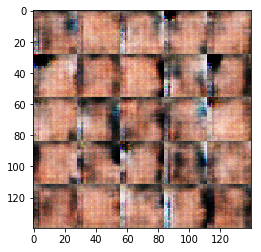

Epoch 1/1 steps 710,  Discriminator Loss: 1.4675,  Generator Loss: 1.2141
Epoch 1/1 steps 720,  Discriminator Loss: 1.2562,  Generator Loss: 1.1215
Epoch 1/1 steps 730,  Discriminator Loss: 1.4303,  Generator Loss: 0.9626
Epoch 1/1 steps 740,  Discriminator Loss: 1.2778,  Generator Loss: 0.9216
Epoch 1/1 steps 750,  Discriminator Loss: 1.3002,  Generator Loss: 1.1234
Epoch 1/1 steps 760,  Discriminator Loss: 1.5047,  Generator Loss: 1.0276
Epoch 1/1 steps 770,  Discriminator Loss: 1.4198,  Generator Loss: 1.0329
Epoch 1/1 steps 780,  Discriminator Loss: 1.4662,  Generator Loss: 1.0153
Epoch 1/1 steps 790,  Discriminator Loss: 1.2537,  Generator Loss: 1.1703
Epoch 1/1 steps 800,  Discriminator Loss: 1.4321,  Generator Loss: 0.8607


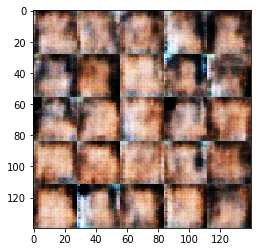

Epoch 1/1 steps 810,  Discriminator Loss: 1.3815,  Generator Loss: 1.0069
Epoch 1/1 steps 820,  Discriminator Loss: 1.3963,  Generator Loss: 0.9649
Epoch 1/1 steps 830,  Discriminator Loss: 1.3666,  Generator Loss: 0.7746
Epoch 1/1 steps 840,  Discriminator Loss: 1.3108,  Generator Loss: 1.1152
Epoch 1/1 steps 850,  Discriminator Loss: 1.5340,  Generator Loss: 0.9882
Epoch 1/1 steps 860,  Discriminator Loss: 1.3688,  Generator Loss: 1.0263
Epoch 1/1 steps 870,  Discriminator Loss: 1.3052,  Generator Loss: 1.0345
Epoch 1/1 steps 880,  Discriminator Loss: 1.5186,  Generator Loss: 0.6985
Epoch 1/1 steps 890,  Discriminator Loss: 1.3935,  Generator Loss: 0.9507
Epoch 1/1 steps 900,  Discriminator Loss: 1.2835,  Generator Loss: 0.9635


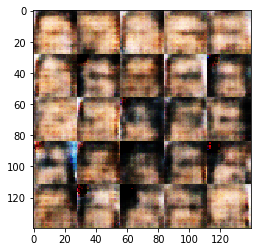

Epoch 1/1 steps 910,  Discriminator Loss: 1.4294,  Generator Loss: 1.3248
Epoch 1/1 steps 920,  Discriminator Loss: 1.2528,  Generator Loss: 0.9896
Epoch 1/1 steps 930,  Discriminator Loss: 1.3385,  Generator Loss: 0.9694
Epoch 1/1 steps 940,  Discriminator Loss: 1.3265,  Generator Loss: 1.0348
Epoch 1/1 steps 950,  Discriminator Loss: 1.2420,  Generator Loss: 1.1807
Epoch 1/1 steps 960,  Discriminator Loss: 1.4011,  Generator Loss: 1.0537
Epoch 1/1 steps 970,  Discriminator Loss: 1.2220,  Generator Loss: 0.9746
Epoch 1/1 steps 980,  Discriminator Loss: 1.5579,  Generator Loss: 0.8205
Epoch 1/1 steps 990,  Discriminator Loss: 1.3072,  Generator Loss: 0.7497
Epoch 1/1 steps 1000,  Discriminator Loss: 1.3573,  Generator Loss: 0.9168


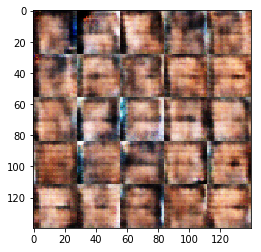

Epoch 1/1 steps 1010,  Discriminator Loss: 1.3638,  Generator Loss: 1.0955
Epoch 1/1 steps 1020,  Discriminator Loss: 1.3451,  Generator Loss: 0.9297
Epoch 1/1 steps 1030,  Discriminator Loss: 1.2989,  Generator Loss: 1.0543
Epoch 1/1 steps 1040,  Discriminator Loss: 1.3789,  Generator Loss: 0.9502
Epoch 1/1 steps 1050,  Discriminator Loss: 1.2189,  Generator Loss: 1.0498
Epoch 1/1 steps 1060,  Discriminator Loss: 1.2872,  Generator Loss: 0.8457
Epoch 1/1 steps 1070,  Discriminator Loss: 1.3981,  Generator Loss: 0.8380
Epoch 1/1 steps 1080,  Discriminator Loss: 1.6360,  Generator Loss: 0.7415
Epoch 1/1 steps 1090,  Discriminator Loss: 1.5174,  Generator Loss: 0.9113
Epoch 1/1 steps 1100,  Discriminator Loss: 1.3990,  Generator Loss: 0.9977


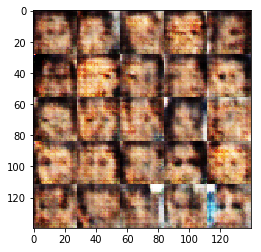

Epoch 1/1 steps 1110,  Discriminator Loss: 1.2755,  Generator Loss: 0.9950
Epoch 1/1 steps 1120,  Discriminator Loss: 1.4248,  Generator Loss: 0.8622
Epoch 1/1 steps 1130,  Discriminator Loss: 1.2746,  Generator Loss: 0.9111
Epoch 1/1 steps 1140,  Discriminator Loss: 1.4988,  Generator Loss: 0.6606
Epoch 1/1 steps 1150,  Discriminator Loss: 1.3976,  Generator Loss: 0.8404
Epoch 1/1 steps 1160,  Discriminator Loss: 1.2810,  Generator Loss: 0.9035
Epoch 1/1 steps 1170,  Discriminator Loss: 1.5195,  Generator Loss: 0.8076
Epoch 1/1 steps 1180,  Discriminator Loss: 1.2846,  Generator Loss: 0.8118
Epoch 1/1 steps 1190,  Discriminator Loss: 1.3771,  Generator Loss: 0.8692
Epoch 1/1 steps 1200,  Discriminator Loss: 1.2801,  Generator Loss: 0.8250


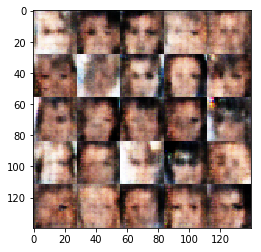

Epoch 1/1 steps 1210,  Discriminator Loss: 1.2546,  Generator Loss: 0.9758
Epoch 1/1 steps 1220,  Discriminator Loss: 1.2694,  Generator Loss: 1.0204
Epoch 1/1 steps 1230,  Discriminator Loss: 1.5352,  Generator Loss: 0.9558
Epoch 1/1 steps 1240,  Discriminator Loss: 1.2621,  Generator Loss: 0.9813
Epoch 1/1 steps 1250,  Discriminator Loss: 1.3518,  Generator Loss: 0.8412
Epoch 1/1 steps 1260,  Discriminator Loss: 1.2337,  Generator Loss: 1.0278
Epoch 1/1 steps 1270,  Discriminator Loss: 1.3581,  Generator Loss: 0.9367
Epoch 1/1 steps 1280,  Discriminator Loss: 1.4566,  Generator Loss: 0.8949
Epoch 1/1 steps 1290,  Discriminator Loss: 1.2956,  Generator Loss: 0.8856
Epoch 1/1 steps 1300,  Discriminator Loss: 1.3922,  Generator Loss: 0.8600


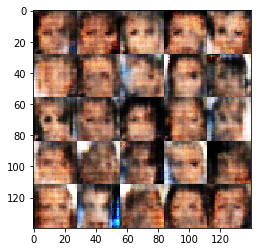

Epoch 1/1 steps 1310,  Discriminator Loss: 1.3372,  Generator Loss: 0.8131
Epoch 1/1 steps 1320,  Discriminator Loss: 1.2334,  Generator Loss: 0.9266
Epoch 1/1 steps 1330,  Discriminator Loss: 1.3083,  Generator Loss: 0.9095
Epoch 1/1 steps 1340,  Discriminator Loss: 1.4405,  Generator Loss: 0.8588
Epoch 1/1 steps 1350,  Discriminator Loss: 1.4286,  Generator Loss: 0.9892
Epoch 1/1 steps 1360,  Discriminator Loss: 1.4480,  Generator Loss: 0.9324
Epoch 1/1 steps 1370,  Discriminator Loss: 1.2293,  Generator Loss: 0.9259
Epoch 1/1 steps 1380,  Discriminator Loss: 1.3519,  Generator Loss: 0.8512
Epoch 1/1 steps 1390,  Discriminator Loss: 1.4787,  Generator Loss: 0.8132
Epoch 1/1 steps 1400,  Discriminator Loss: 1.2752,  Generator Loss: 1.0220


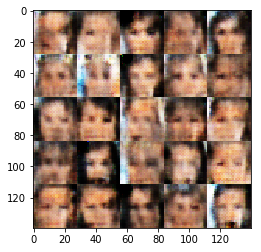

Epoch 1/1 steps 1410,  Discriminator Loss: 1.3233,  Generator Loss: 1.0203
Epoch 1/1 steps 1420,  Discriminator Loss: 1.4559,  Generator Loss: 0.8461
Epoch 1/1 steps 1430,  Discriminator Loss: 1.3677,  Generator Loss: 0.8705
Epoch 1/1 steps 1440,  Discriminator Loss: 1.3203,  Generator Loss: 0.9465
Epoch 1/1 steps 1450,  Discriminator Loss: 1.5151,  Generator Loss: 0.7793
Epoch 1/1 steps 1460,  Discriminator Loss: 1.3585,  Generator Loss: 0.9162
Epoch 1/1 steps 1470,  Discriminator Loss: 1.3027,  Generator Loss: 0.9383
Epoch 1/1 steps 1480,  Discriminator Loss: 1.3614,  Generator Loss: 0.9965
Epoch 1/1 steps 1490,  Discriminator Loss: 1.4681,  Generator Loss: 0.8668
Epoch 1/1 steps 1500,  Discriminator Loss: 1.2411,  Generator Loss: 0.8413


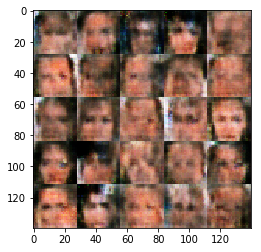

Epoch 1/1 steps 1510,  Discriminator Loss: 1.5043,  Generator Loss: 0.8220
Epoch 1/1 steps 1520,  Discriminator Loss: 1.2598,  Generator Loss: 0.8942
Epoch 1/1 steps 1530,  Discriminator Loss: 1.3485,  Generator Loss: 0.8156
Epoch 1/1 steps 1540,  Discriminator Loss: 1.3623,  Generator Loss: 0.8714
Epoch 1/1 steps 1550,  Discriminator Loss: 1.3597,  Generator Loss: 0.9417
Epoch 1/1 steps 1560,  Discriminator Loss: 1.3488,  Generator Loss: 0.8586
Epoch 1/1 steps 1570,  Discriminator Loss: 1.3344,  Generator Loss: 0.9164
Epoch 1/1 steps 1580,  Discriminator Loss: 1.3499,  Generator Loss: 0.8949
Epoch 1/1 steps 1590,  Discriminator Loss: 1.2845,  Generator Loss: 0.9783
Epoch 1/1 steps 1600,  Discriminator Loss: 1.3362,  Generator Loss: 0.8469


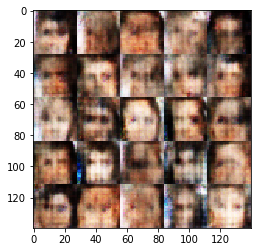

Epoch 1/1 steps 1610,  Discriminator Loss: 1.2906,  Generator Loss: 0.8874
Epoch 1/1 steps 1620,  Discriminator Loss: 1.3953,  Generator Loss: 0.9457
Epoch 1/1 steps 1630,  Discriminator Loss: 1.3175,  Generator Loss: 0.8952
Epoch 1/1 steps 1640,  Discriminator Loss: 1.4319,  Generator Loss: 0.7706
Epoch 1/1 steps 1650,  Discriminator Loss: 1.5545,  Generator Loss: 0.7377
Epoch 1/1 steps 1660,  Discriminator Loss: 1.2752,  Generator Loss: 0.8825
Epoch 1/1 steps 1670,  Discriminator Loss: 1.3828,  Generator Loss: 0.8634
Epoch 1/1 steps 1680,  Discriminator Loss: 1.3607,  Generator Loss: 0.9491
Epoch 1/1 steps 1690,  Discriminator Loss: 1.3662,  Generator Loss: 0.9497
Epoch 1/1 steps 1700,  Discriminator Loss: 1.3996,  Generator Loss: 0.7872


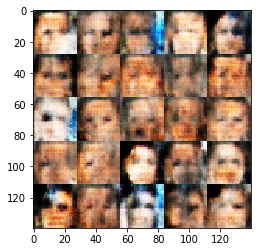

Epoch 1/1 steps 1710,  Discriminator Loss: 1.3088,  Generator Loss: 0.8576
Epoch 1/1 steps 1720,  Discriminator Loss: 1.3037,  Generator Loss: 0.9232
Epoch 1/1 steps 1730,  Discriminator Loss: 1.2478,  Generator Loss: 0.9547
Epoch 1/1 steps 1740,  Discriminator Loss: 1.2488,  Generator Loss: 0.8939
Epoch 1/1 steps 1750,  Discriminator Loss: 1.3867,  Generator Loss: 0.8212
Epoch 1/1 steps 1760,  Discriminator Loss: 1.3285,  Generator Loss: 0.8937
Epoch 1/1 steps 1770,  Discriminator Loss: 1.3977,  Generator Loss: 0.9463
Epoch 1/1 steps 1780,  Discriminator Loss: 1.3802,  Generator Loss: 0.9004
Epoch 1/1 steps 1790,  Discriminator Loss: 1.4008,  Generator Loss: 0.8310
Epoch 1/1 steps 1800,  Discriminator Loss: 1.3847,  Generator Loss: 0.8958


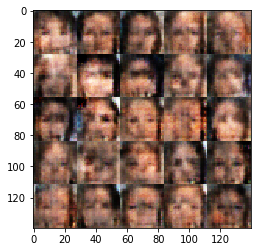

Epoch 1/1 steps 1810,  Discriminator Loss: 1.2786,  Generator Loss: 0.9486
Epoch 1/1 steps 1820,  Discriminator Loss: 1.4166,  Generator Loss: 0.7652
Epoch 1/1 steps 1830,  Discriminator Loss: 1.3054,  Generator Loss: 0.8691
Epoch 1/1 steps 1840,  Discriminator Loss: 1.3494,  Generator Loss: 0.8221
Epoch 1/1 steps 1850,  Discriminator Loss: 1.2916,  Generator Loss: 1.0019
Epoch 1/1 steps 1860,  Discriminator Loss: 1.3034,  Generator Loss: 0.9171
Epoch 1/1 steps 1870,  Discriminator Loss: 1.3461,  Generator Loss: 0.9241
Epoch 1/1 steps 1880,  Discriminator Loss: 1.3792,  Generator Loss: 0.9031
Epoch 1/1 steps 1890,  Discriminator Loss: 1.3343,  Generator Loss: 0.9191
Epoch 1/1 steps 1900,  Discriminator Loss: 1.3201,  Generator Loss: 0.9067


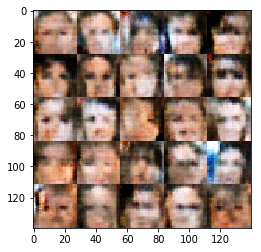

Epoch 1/1 steps 1910,  Discriminator Loss: 1.3709,  Generator Loss: 0.7900
Epoch 1/1 steps 1920,  Discriminator Loss: 1.3751,  Generator Loss: 0.8159
Epoch 1/1 steps 1930,  Discriminator Loss: 1.3729,  Generator Loss: 0.8218
Epoch 1/1 steps 1940,  Discriminator Loss: 1.2448,  Generator Loss: 0.9210
Epoch 1/1 steps 1950,  Discriminator Loss: 1.2231,  Generator Loss: 0.8698
Epoch 1/1 steps 1960,  Discriminator Loss: 1.3166,  Generator Loss: 0.8885
Epoch 1/1 steps 1970,  Discriminator Loss: 1.2353,  Generator Loss: 0.9160
Epoch 1/1 steps 1980,  Discriminator Loss: 1.3839,  Generator Loss: 0.9048
Epoch 1/1 steps 1990,  Discriminator Loss: 1.3649,  Generator Loss: 0.9444
Epoch 1/1 steps 2000,  Discriminator Loss: 1.3535,  Generator Loss: 0.8263


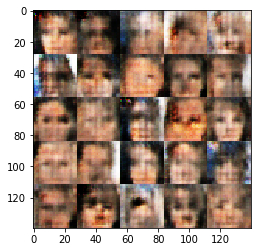

Epoch 1/1 steps 2010,  Discriminator Loss: 1.3410,  Generator Loss: 0.9325
Epoch 1/1 steps 2020,  Discriminator Loss: 1.3565,  Generator Loss: 0.8899
Epoch 1/1 steps 2030,  Discriminator Loss: 1.3916,  Generator Loss: 0.9581
Epoch 1/1 steps 2040,  Discriminator Loss: 1.3339,  Generator Loss: 0.7960
Epoch 1/1 steps 2050,  Discriminator Loss: 1.3031,  Generator Loss: 0.9109
Epoch 1/1 steps 2060,  Discriminator Loss: 1.4674,  Generator Loss: 0.7599
Epoch 1/1 steps 2070,  Discriminator Loss: 1.3863,  Generator Loss: 0.8060
Epoch 1/1 steps 2080,  Discriminator Loss: 1.3582,  Generator Loss: 0.8399
Epoch 1/1 steps 2090,  Discriminator Loss: 1.3427,  Generator Loss: 0.8554
Epoch 1/1 steps 2100,  Discriminator Loss: 1.3053,  Generator Loss: 1.0282


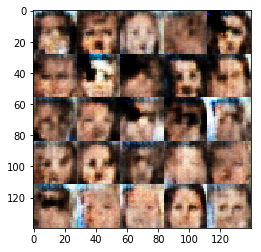

Epoch 1/1 steps 2110,  Discriminator Loss: 1.2708,  Generator Loss: 0.9923
Epoch 1/1 steps 2120,  Discriminator Loss: 1.2514,  Generator Loss: 1.0781
Epoch 1/1 steps 2130,  Discriminator Loss: 1.3121,  Generator Loss: 0.8532
Epoch 1/1 steps 2140,  Discriminator Loss: 1.2890,  Generator Loss: 0.8271
Epoch 1/1 steps 2150,  Discriminator Loss: 1.3468,  Generator Loss: 0.8274
Epoch 1/1 steps 2160,  Discriminator Loss: 1.3194,  Generator Loss: 0.8625
Epoch 1/1 steps 2170,  Discriminator Loss: 1.2958,  Generator Loss: 0.8442
Epoch 1/1 steps 2180,  Discriminator Loss: 1.4344,  Generator Loss: 0.7847
Epoch 1/1 steps 2190,  Discriminator Loss: 1.4165,  Generator Loss: 0.7922
Epoch 1/1 steps 2200,  Discriminator Loss: 1.2204,  Generator Loss: 0.9254


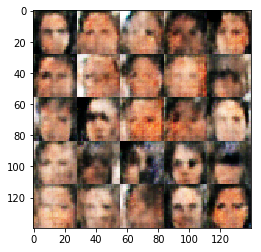

Epoch 1/1 steps 2210,  Discriminator Loss: 1.4340,  Generator Loss: 0.7621
Epoch 1/1 steps 2220,  Discriminator Loss: 1.3895,  Generator Loss: 0.8635
Epoch 1/1 steps 2230,  Discriminator Loss: 1.4455,  Generator Loss: 0.7415
Epoch 1/1 steps 2240,  Discriminator Loss: 1.3841,  Generator Loss: 0.8354
Epoch 1/1 steps 2250,  Discriminator Loss: 1.4339,  Generator Loss: 0.7689
Epoch 1/1 steps 2260,  Discriminator Loss: 1.3308,  Generator Loss: 0.8421
Epoch 1/1 steps 2270,  Discriminator Loss: 1.2682,  Generator Loss: 0.9902
Epoch 1/1 steps 2280,  Discriminator Loss: 1.3050,  Generator Loss: 0.8969
Epoch 1/1 steps 2290,  Discriminator Loss: 1.2724,  Generator Loss: 0.8935
Epoch 1/1 steps 2300,  Discriminator Loss: 1.3852,  Generator Loss: 0.8420


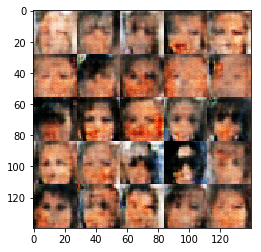

Epoch 1/1 steps 2310,  Discriminator Loss: 1.4077,  Generator Loss: 0.7337
Epoch 1/1 steps 2320,  Discriminator Loss: 1.3719,  Generator Loss: 0.8774
Epoch 1/1 steps 2330,  Discriminator Loss: 1.4073,  Generator Loss: 0.8534
Epoch 1/1 steps 2340,  Discriminator Loss: 1.3743,  Generator Loss: 0.8568
Epoch 1/1 steps 2350,  Discriminator Loss: 1.4180,  Generator Loss: 0.8824
Epoch 1/1 steps 2360,  Discriminator Loss: 1.3799,  Generator Loss: 0.8208
Epoch 1/1 steps 2370,  Discriminator Loss: 1.2485,  Generator Loss: 0.8404
Epoch 1/1 steps 2380,  Discriminator Loss: 1.3443,  Generator Loss: 0.8810
Epoch 1/1 steps 2390,  Discriminator Loss: 1.3500,  Generator Loss: 0.8914
Epoch 1/1 steps 2400,  Discriminator Loss: 1.3294,  Generator Loss: 0.8205


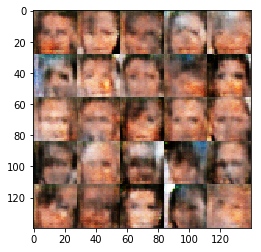

Epoch 1/1 steps 2410,  Discriminator Loss: 1.3499,  Generator Loss: 0.8856
Epoch 1/1 steps 2420,  Discriminator Loss: 1.3146,  Generator Loss: 1.0091
Epoch 1/1 steps 2430,  Discriminator Loss: 1.3012,  Generator Loss: 0.8439
Epoch 1/1 steps 2440,  Discriminator Loss: 1.2929,  Generator Loss: 0.9412
Epoch 1/1 steps 2450,  Discriminator Loss: 1.2597,  Generator Loss: 0.9352
Epoch 1/1 steps 2460,  Discriminator Loss: 1.4473,  Generator Loss: 0.8210
Epoch 1/1 steps 2470,  Discriminator Loss: 1.3342,  Generator Loss: 0.8800
Epoch 1/1 steps 2480,  Discriminator Loss: 1.4295,  Generator Loss: 0.7938
Epoch 1/1 steps 2490,  Discriminator Loss: 1.4358,  Generator Loss: 0.8263
Epoch 1/1 steps 2500,  Discriminator Loss: 1.3887,  Generator Loss: 0.9076


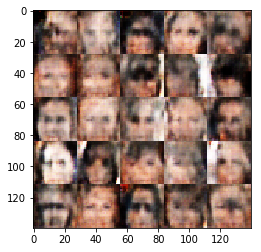

Epoch 1/1 steps 2510,  Discriminator Loss: 1.2342,  Generator Loss: 1.0285
Epoch 1/1 steps 2520,  Discriminator Loss: 1.2848,  Generator Loss: 0.8051
Epoch 1/1 steps 2530,  Discriminator Loss: 1.4224,  Generator Loss: 0.8972
Epoch 1/1 steps 2540,  Discriminator Loss: 1.2914,  Generator Loss: 0.8677
Epoch 1/1 steps 2550,  Discriminator Loss: 1.3555,  Generator Loss: 0.8350
Epoch 1/1 steps 2560,  Discriminator Loss: 1.3574,  Generator Loss: 0.8987
Epoch 1/1 steps 2570,  Discriminator Loss: 1.3142,  Generator Loss: 0.8789
Epoch 1/1 steps 2580,  Discriminator Loss: 1.1697,  Generator Loss: 0.9943
Epoch 1/1 steps 2590,  Discriminator Loss: 1.3428,  Generator Loss: 0.8997
Epoch 1/1 steps 2600,  Discriminator Loss: 1.3394,  Generator Loss: 0.9177


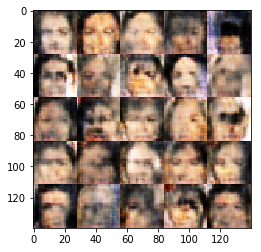

Epoch 1/1 steps 2610,  Discriminator Loss: 1.3037,  Generator Loss: 0.9138
Epoch 1/1 steps 2620,  Discriminator Loss: 1.4596,  Generator Loss: 0.8416
Epoch 1/1 steps 2630,  Discriminator Loss: 1.4042,  Generator Loss: 0.8863
Epoch 1/1 steps 2640,  Discriminator Loss: 1.4443,  Generator Loss: 0.8342
Epoch 1/1 steps 2650,  Discriminator Loss: 1.2359,  Generator Loss: 0.9441
Epoch 1/1 steps 2660,  Discriminator Loss: 1.3247,  Generator Loss: 0.8266
Epoch 1/1 steps 2670,  Discriminator Loss: 1.3626,  Generator Loss: 0.8720
Epoch 1/1 steps 2680,  Discriminator Loss: 1.4049,  Generator Loss: 0.7888
Epoch 1/1 steps 2690,  Discriminator Loss: 1.4537,  Generator Loss: 0.8332
Epoch 1/1 steps 2700,  Discriminator Loss: 1.3696,  Generator Loss: 0.8667


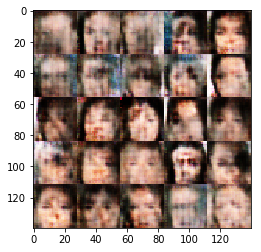

Epoch 1/1 steps 2710,  Discriminator Loss: 1.3251,  Generator Loss: 0.8788
Epoch 1/1 steps 2720,  Discriminator Loss: 1.2847,  Generator Loss: 0.9276
Epoch 1/1 steps 2730,  Discriminator Loss: 1.2958,  Generator Loss: 0.8801
Epoch 1/1 steps 2740,  Discriminator Loss: 1.2899,  Generator Loss: 0.8380
Epoch 1/1 steps 2750,  Discriminator Loss: 1.3835,  Generator Loss: 0.7086
Epoch 1/1 steps 2760,  Discriminator Loss: 1.3115,  Generator Loss: 0.8636
Epoch 1/1 steps 2770,  Discriminator Loss: 1.4175,  Generator Loss: 0.7607
Epoch 1/1 steps 2780,  Discriminator Loss: 1.2682,  Generator Loss: 0.7854
Epoch 1/1 steps 2790,  Discriminator Loss: 1.2826,  Generator Loss: 0.9735
Epoch 1/1 steps 2800,  Discriminator Loss: 1.3972,  Generator Loss: 0.8761


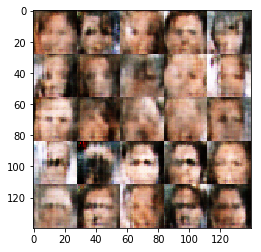

Epoch 1/1 steps 2810,  Discriminator Loss: 1.3569,  Generator Loss: 0.8330
Epoch 1/1 steps 2820,  Discriminator Loss: 1.3279,  Generator Loss: 0.8946
Epoch 1/1 steps 2830,  Discriminator Loss: 1.3276,  Generator Loss: 0.8282
Epoch 1/1 steps 2840,  Discriminator Loss: 1.3822,  Generator Loss: 0.7799
Epoch 1/1 steps 2850,  Discriminator Loss: 1.3559,  Generator Loss: 0.7743
Epoch 1/1 steps 2860,  Discriminator Loss: 1.3407,  Generator Loss: 0.8791
Epoch 1/1 steps 2870,  Discriminator Loss: 1.3173,  Generator Loss: 0.7831
Epoch 1/1 steps 2880,  Discriminator Loss: 1.4853,  Generator Loss: 0.7427
Epoch 1/1 steps 2890,  Discriminator Loss: 1.4040,  Generator Loss: 0.7468
Epoch 1/1 steps 2900,  Discriminator Loss: 1.2827,  Generator Loss: 0.9166


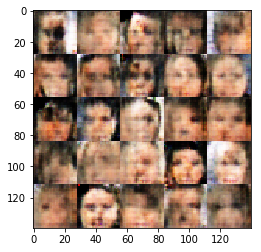

Epoch 1/1 steps 2910,  Discriminator Loss: 1.3358,  Generator Loss: 0.8077
Epoch 1/1 steps 2920,  Discriminator Loss: 1.3234,  Generator Loss: 0.8285
Epoch 1/1 steps 2930,  Discriminator Loss: 1.3867,  Generator Loss: 0.8374
Epoch 1/1 steps 2940,  Discriminator Loss: 1.3187,  Generator Loss: 0.8689
Epoch 1/1 steps 2950,  Discriminator Loss: 1.2975,  Generator Loss: 0.9200
Epoch 1/1 steps 2960,  Discriminator Loss: 1.2941,  Generator Loss: 0.8632
Epoch 1/1 steps 2970,  Discriminator Loss: 1.3650,  Generator Loss: 0.8428
Epoch 1/1 steps 2980,  Discriminator Loss: 1.2783,  Generator Loss: 0.9429
Epoch 1/1 steps 2990,  Discriminator Loss: 1.3001,  Generator Loss: 0.8207
Epoch 1/1 steps 3000,  Discriminator Loss: 1.2813,  Generator Loss: 0.8190


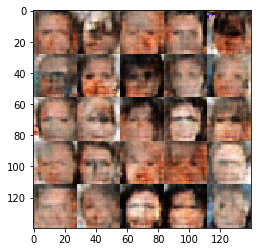

Epoch 1/1 steps 3010,  Discriminator Loss: 1.3057,  Generator Loss: 0.7510
Epoch 1/1 steps 3020,  Discriminator Loss: 1.4228,  Generator Loss: 0.7671
Epoch 1/1 steps 3030,  Discriminator Loss: 1.2827,  Generator Loss: 0.9225
Epoch 1/1 steps 3040,  Discriminator Loss: 1.2838,  Generator Loss: 0.8960
Epoch 1/1 steps 3050,  Discriminator Loss: 1.2914,  Generator Loss: 0.9115
Epoch 1/1 steps 3060,  Discriminator Loss: 1.3278,  Generator Loss: 0.9293
Epoch 1/1 steps 3070,  Discriminator Loss: 1.3625,  Generator Loss: 0.8963
Epoch 1/1 steps 3080,  Discriminator Loss: 1.3401,  Generator Loss: 0.8837
Epoch 1/1 steps 3090,  Discriminator Loss: 1.3306,  Generator Loss: 0.7956
Epoch 1/1 steps 3100,  Discriminator Loss: 1.2988,  Generator Loss: 0.9276


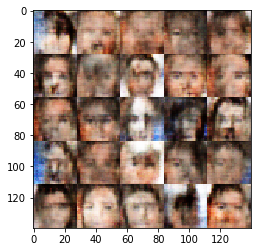

Epoch 1/1 steps 3110,  Discriminator Loss: 1.3630,  Generator Loss: 0.8180
Epoch 1/1 steps 3120,  Discriminator Loss: 1.3218,  Generator Loss: 0.8813
Epoch 1/1 steps 3130,  Discriminator Loss: 1.3010,  Generator Loss: 0.9449
Epoch 1/1 steps 3140,  Discriminator Loss: 1.3777,  Generator Loss: 0.8546
Epoch 1/1 steps 3150,  Discriminator Loss: 1.3153,  Generator Loss: 0.8491
Epoch 1/1 steps 3160,  Discriminator Loss: 1.3386,  Generator Loss: 0.9182
Epoch 1/1 steps 3170,  Discriminator Loss: 1.2991,  Generator Loss: 0.8389
Epoch 1/1 steps 3180,  Discriminator Loss: 1.2938,  Generator Loss: 0.8803
Epoch 1/1 steps 3190,  Discriminator Loss: 1.3725,  Generator Loss: 0.8054
Epoch 1/1 steps 3200,  Discriminator Loss: 1.2841,  Generator Loss: 0.8367


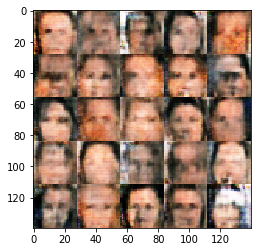

Epoch 1/1 steps 3210,  Discriminator Loss: 1.3434,  Generator Loss: 0.9273
Epoch 1/1 steps 3220,  Discriminator Loss: 1.3644,  Generator Loss: 0.8731
Epoch 1/1 steps 3230,  Discriminator Loss: 1.3979,  Generator Loss: 0.8497
Epoch 1/1 steps 3240,  Discriminator Loss: 1.2662,  Generator Loss: 1.0067
Epoch 1/1 steps 3250,  Discriminator Loss: 1.4308,  Generator Loss: 0.8417
Epoch 1/1 steps 3260,  Discriminator Loss: 1.3466,  Generator Loss: 0.8150
Epoch 1/1 steps 3270,  Discriminator Loss: 1.2864,  Generator Loss: 0.8742
Epoch 1/1 steps 3280,  Discriminator Loss: 1.3462,  Generator Loss: 0.8728
Epoch 1/1 steps 3290,  Discriminator Loss: 1.3882,  Generator Loss: 0.8916
Epoch 1/1 steps 3300,  Discriminator Loss: 1.3720,  Generator Loss: 0.8896


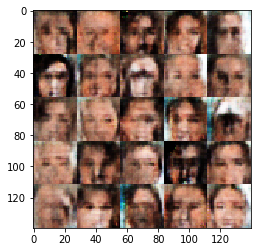

Epoch 1/1 steps 3310,  Discriminator Loss: 1.2694,  Generator Loss: 0.8119
Epoch 1/1 steps 3320,  Discriminator Loss: 1.3657,  Generator Loss: 0.9044
Epoch 1/1 steps 3330,  Discriminator Loss: 1.3220,  Generator Loss: 0.8951
Epoch 1/1 steps 3340,  Discriminator Loss: 1.3362,  Generator Loss: 0.8329
Epoch 1/1 steps 3350,  Discriminator Loss: 1.2646,  Generator Loss: 0.8857
Epoch 1/1 steps 3360,  Discriminator Loss: 1.3246,  Generator Loss: 0.9085
Epoch 1/1 steps 3370,  Discriminator Loss: 1.3446,  Generator Loss: 0.8582
Epoch 1/1 steps 3380,  Discriminator Loss: 1.3445,  Generator Loss: 0.8508
Epoch 1/1 steps 3390,  Discriminator Loss: 1.4120,  Generator Loss: 0.8803
Epoch 1/1 steps 3400,  Discriminator Loss: 1.2878,  Generator Loss: 0.8830


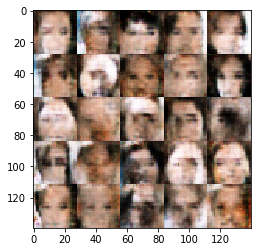

Epoch 1/1 steps 3410,  Discriminator Loss: 1.3744,  Generator Loss: 0.7616
Epoch 1/1 steps 3420,  Discriminator Loss: 1.2792,  Generator Loss: 0.8082
Epoch 1/1 steps 3430,  Discriminator Loss: 1.2894,  Generator Loss: 0.8641
Epoch 1/1 steps 3440,  Discriminator Loss: 1.4045,  Generator Loss: 0.7771
Epoch 1/1 steps 3450,  Discriminator Loss: 1.3714,  Generator Loss: 0.8195
Epoch 1/1 steps 3460,  Discriminator Loss: 1.3128,  Generator Loss: 0.9550
Epoch 1/1 steps 3470,  Discriminator Loss: 1.3065,  Generator Loss: 0.8715
Epoch 1/1 steps 3480,  Discriminator Loss: 1.2842,  Generator Loss: 0.8814
Epoch 1/1 steps 3490,  Discriminator Loss: 1.3693,  Generator Loss: 0.8559
Epoch 1/1 steps 3500,  Discriminator Loss: 1.4191,  Generator Loss: 0.8151


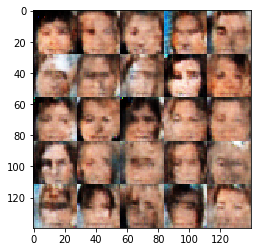

Epoch 1/1 steps 3510,  Discriminator Loss: 1.3184,  Generator Loss: 0.7727
Epoch 1/1 steps 3520,  Discriminator Loss: 1.4838,  Generator Loss: 0.7698
Epoch 1/1 steps 3530,  Discriminator Loss: 1.3942,  Generator Loss: 0.8334
Epoch 1/1 steps 3540,  Discriminator Loss: 1.2955,  Generator Loss: 0.8349
Epoch 1/1 steps 3550,  Discriminator Loss: 1.3754,  Generator Loss: 0.8097
Epoch 1/1 steps 3560,  Discriminator Loss: 1.2902,  Generator Loss: 0.8934
Epoch 1/1 steps 3570,  Discriminator Loss: 1.3143,  Generator Loss: 0.8073
Epoch 1/1 steps 3580,  Discriminator Loss: 1.3526,  Generator Loss: 0.7928
Epoch 1/1 steps 3590,  Discriminator Loss: 1.3633,  Generator Loss: 0.7984
Epoch 1/1 steps 3600,  Discriminator Loss: 1.3417,  Generator Loss: 0.7688


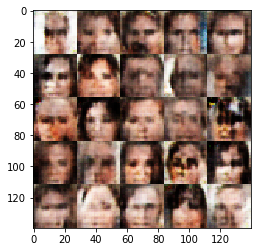

Epoch 1/1 steps 3610,  Discriminator Loss: 1.3556,  Generator Loss: 0.8138
Epoch 1/1 steps 3620,  Discriminator Loss: 1.2416,  Generator Loss: 0.8588
Epoch 1/1 steps 3630,  Discriminator Loss: 1.3454,  Generator Loss: 0.8234
Epoch 1/1 steps 3640,  Discriminator Loss: 1.3821,  Generator Loss: 0.8595
Epoch 1/1 steps 3650,  Discriminator Loss: 1.3716,  Generator Loss: 0.8348
Epoch 1/1 steps 3660,  Discriminator Loss: 1.3189,  Generator Loss: 0.7780
Epoch 1/1 steps 3670,  Discriminator Loss: 1.3116,  Generator Loss: 0.8313
Epoch 1/1 steps 3680,  Discriminator Loss: 1.3884,  Generator Loss: 0.9165
Epoch 1/1 steps 3690,  Discriminator Loss: 1.3202,  Generator Loss: 0.9110
Epoch 1/1 steps 3700,  Discriminator Loss: 1.3822,  Generator Loss: 0.7809


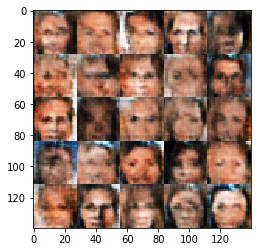

Epoch 1/1 steps 3710,  Discriminator Loss: 1.3572,  Generator Loss: 0.8334
Epoch 1/1 steps 3720,  Discriminator Loss: 1.3300,  Generator Loss: 0.7706
Epoch 1/1 steps 3730,  Discriminator Loss: 1.3664,  Generator Loss: 0.8158
Epoch 1/1 steps 3740,  Discriminator Loss: 1.3801,  Generator Loss: 0.8434
Epoch 1/1 steps 3750,  Discriminator Loss: 1.3646,  Generator Loss: 0.8768
Epoch 1/1 steps 3760,  Discriminator Loss: 1.3528,  Generator Loss: 0.8306
Epoch 1/1 steps 3770,  Discriminator Loss: 1.3446,  Generator Loss: 0.9220
Epoch 1/1 steps 3780,  Discriminator Loss: 1.2731,  Generator Loss: 0.9654
Epoch 1/1 steps 3790,  Discriminator Loss: 1.3304,  Generator Loss: 0.9217
Epoch 1/1 steps 3800,  Discriminator Loss: 1.3356,  Generator Loss: 0.8212


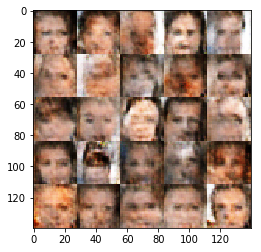

Epoch 1/1 steps 3810,  Discriminator Loss: 1.3470,  Generator Loss: 0.8821
Epoch 1/1 steps 3820,  Discriminator Loss: 1.2662,  Generator Loss: 0.8309
Epoch 1/1 steps 3830,  Discriminator Loss: 1.3534,  Generator Loss: 0.8111
Epoch 1/1 steps 3840,  Discriminator Loss: 1.3228,  Generator Loss: 0.8519
Epoch 1/1 steps 3850,  Discriminator Loss: 1.2970,  Generator Loss: 0.9391
Epoch 1/1 steps 3860,  Discriminator Loss: 1.2728,  Generator Loss: 0.9498
Epoch 1/1 steps 3870,  Discriminator Loss: 1.3627,  Generator Loss: 0.8198
Epoch 1/1 steps 3880,  Discriminator Loss: 1.3584,  Generator Loss: 0.8219
Epoch 1/1 steps 3890,  Discriminator Loss: 1.3358,  Generator Loss: 0.8276
Epoch 1/1 steps 3900,  Discriminator Loss: 1.3833,  Generator Loss: 0.9030


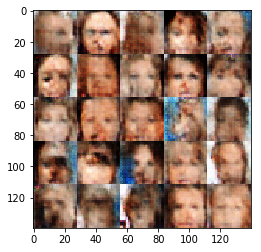

Epoch 1/1 steps 3910,  Discriminator Loss: 1.3494,  Generator Loss: 0.8476
Epoch 1/1 steps 3920,  Discriminator Loss: 1.3688,  Generator Loss: 0.9351
Epoch 1/1 steps 3930,  Discriminator Loss: 1.3706,  Generator Loss: 0.8050
Epoch 1/1 steps 3940,  Discriminator Loss: 1.3819,  Generator Loss: 0.8046
Epoch 1/1 steps 3950,  Discriminator Loss: 1.3838,  Generator Loss: 0.8504
Epoch 1/1 steps 3960,  Discriminator Loss: 1.2398,  Generator Loss: 0.8810
Epoch 1/1 steps 3970,  Discriminator Loss: 1.3027,  Generator Loss: 0.8273
Epoch 1/1 steps 3980,  Discriminator Loss: 1.3152,  Generator Loss: 0.8404
Epoch 1/1 steps 3990,  Discriminator Loss: 1.3384,  Generator Loss: 0.8191
Epoch 1/1 steps 4000,  Discriminator Loss: 1.2896,  Generator Loss: 0.8294


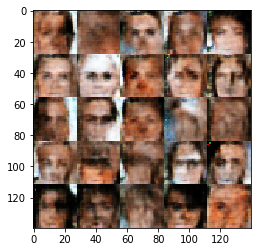

Epoch 1/1 steps 4010,  Discriminator Loss: 1.4870,  Generator Loss: 0.6896
Epoch 1/1 steps 4020,  Discriminator Loss: 1.3306,  Generator Loss: 0.8361
Epoch 1/1 steps 4030,  Discriminator Loss: 1.3738,  Generator Loss: 0.8474
Epoch 1/1 steps 4040,  Discriminator Loss: 1.3457,  Generator Loss: 0.9050
Epoch 1/1 steps 4050,  Discriminator Loss: 1.3808,  Generator Loss: 0.8421
Epoch 1/1 steps 4060,  Discriminator Loss: 1.3795,  Generator Loss: 0.8460
Epoch 1/1 steps 4070,  Discriminator Loss: 1.3209,  Generator Loss: 0.8560
Epoch 1/1 steps 4080,  Discriminator Loss: 1.3218,  Generator Loss: 0.8461
Epoch 1/1 steps 4090,  Discriminator Loss: 1.3681,  Generator Loss: 0.8042
Epoch 1/1 steps 4100,  Discriminator Loss: 1.2953,  Generator Loss: 0.9135


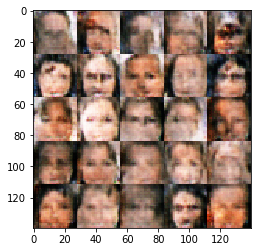

Epoch 1/1 steps 4110,  Discriminator Loss: 1.3799,  Generator Loss: 0.8886
Epoch 1/1 steps 4120,  Discriminator Loss: 1.2827,  Generator Loss: 0.9090
Epoch 1/1 steps 4130,  Discriminator Loss: 1.2752,  Generator Loss: 0.8941
Epoch 1/1 steps 4140,  Discriminator Loss: 1.4249,  Generator Loss: 0.8290
Epoch 1/1 steps 4150,  Discriminator Loss: 1.3556,  Generator Loss: 0.8747
Epoch 1/1 steps 4160,  Discriminator Loss: 1.3919,  Generator Loss: 0.8615
Epoch 1/1 steps 4170,  Discriminator Loss: 1.2310,  Generator Loss: 0.9257
Epoch 1/1 steps 4180,  Discriminator Loss: 1.3378,  Generator Loss: 0.8853
Epoch 1/1 steps 4190,  Discriminator Loss: 1.4135,  Generator Loss: 0.8106
Epoch 1/1 steps 4200,  Discriminator Loss: 1.3842,  Generator Loss: 0.8726


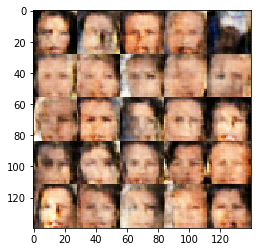

Epoch 1/1 steps 4210,  Discriminator Loss: 1.3598,  Generator Loss: 0.8827
Epoch 1/1 steps 4220,  Discriminator Loss: 1.3060,  Generator Loss: 0.8885
Epoch 1/1 steps 4230,  Discriminator Loss: 1.3205,  Generator Loss: 0.8618
Epoch 1/1 steps 4240,  Discriminator Loss: 1.3650,  Generator Loss: 0.8677
Epoch 1/1 steps 4250,  Discriminator Loss: 1.4184,  Generator Loss: 0.7522
Epoch 1/1 steps 4260,  Discriminator Loss: 1.3152,  Generator Loss: 0.8110
Epoch 1/1 steps 4270,  Discriminator Loss: 1.3667,  Generator Loss: 0.8316
Epoch 1/1 steps 4280,  Discriminator Loss: 1.3618,  Generator Loss: 0.8431
Epoch 1/1 steps 4290,  Discriminator Loss: 1.3896,  Generator Loss: 0.7934
Epoch 1/1 steps 4300,  Discriminator Loss: 1.3864,  Generator Loss: 0.8552


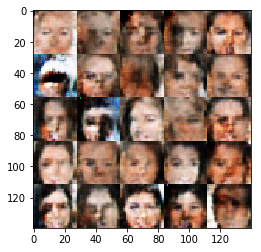

Epoch 1/1 steps 4310,  Discriminator Loss: 1.2530,  Generator Loss: 0.8548
Epoch 1/1 steps 4320,  Discriminator Loss: 1.3440,  Generator Loss: 0.8705
Epoch 1/1 steps 4330,  Discriminator Loss: 1.3264,  Generator Loss: 0.8946
Epoch 1/1 steps 4340,  Discriminator Loss: 1.3363,  Generator Loss: 0.9214
Epoch 1/1 steps 4350,  Discriminator Loss: 1.3202,  Generator Loss: 0.8513
Epoch 1/1 steps 4360,  Discriminator Loss: 1.4315,  Generator Loss: 0.8269
Epoch 1/1 steps 4370,  Discriminator Loss: 1.3957,  Generator Loss: 0.8805
Epoch 1/1 steps 4380,  Discriminator Loss: 1.3313,  Generator Loss: 0.7868
Epoch 1/1 steps 4390,  Discriminator Loss: 1.4051,  Generator Loss: 0.8785
Epoch 1/1 steps 4400,  Discriminator Loss: 1.3606,  Generator Loss: 0.8296


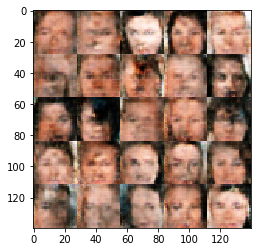

Epoch 1/1 steps 4410,  Discriminator Loss: 1.3758,  Generator Loss: 0.8250
Epoch 1/1 steps 4420,  Discriminator Loss: 1.4096,  Generator Loss: 0.8290
Epoch 1/1 steps 4430,  Discriminator Loss: 1.3560,  Generator Loss: 0.8473
Epoch 1/1 steps 4440,  Discriminator Loss: 1.3779,  Generator Loss: 0.8518
Epoch 1/1 steps 4450,  Discriminator Loss: 1.4048,  Generator Loss: 0.8804
Epoch 1/1 steps 4460,  Discriminator Loss: 1.3430,  Generator Loss: 0.8410
Epoch 1/1 steps 4470,  Discriminator Loss: 1.3735,  Generator Loss: 0.8477
Epoch 1/1 steps 4480,  Discriminator Loss: 1.3311,  Generator Loss: 0.8921
Epoch 1/1 steps 4490,  Discriminator Loss: 1.3313,  Generator Loss: 0.8984
Epoch 1/1 steps 4500,  Discriminator Loss: 1.3267,  Generator Loss: 0.8720


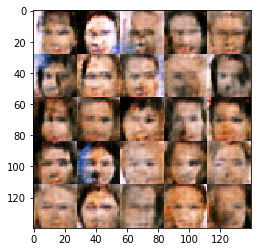

Epoch 1/1 steps 4510,  Discriminator Loss: 1.3430,  Generator Loss: 0.8149
Epoch 1/1 steps 4520,  Discriminator Loss: 1.3279,  Generator Loss: 0.8626
Epoch 1/1 steps 4530,  Discriminator Loss: 1.3345,  Generator Loss: 0.8601
Epoch 1/1 steps 4540,  Discriminator Loss: 1.3256,  Generator Loss: 0.9418
Epoch 1/1 steps 4550,  Discriminator Loss: 1.3108,  Generator Loss: 0.8699
Epoch 1/1 steps 4560,  Discriminator Loss: 1.4046,  Generator Loss: 0.8971
Epoch 1/1 steps 4570,  Discriminator Loss: 1.3378,  Generator Loss: 0.8543
Epoch 1/1 steps 4580,  Discriminator Loss: 1.3122,  Generator Loss: 0.8647
Epoch 1/1 steps 4590,  Discriminator Loss: 1.3262,  Generator Loss: 0.8510
Epoch 1/1 steps 4600,  Discriminator Loss: 1.2874,  Generator Loss: 0.8878


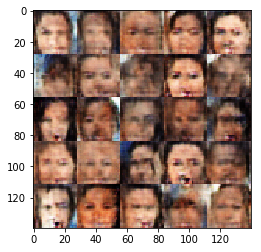

Epoch 1/1 steps 4610,  Discriminator Loss: 1.3113,  Generator Loss: 0.9013
Epoch 1/1 steps 4620,  Discriminator Loss: 1.3107,  Generator Loss: 0.8379
Epoch 1/1 steps 4630,  Discriminator Loss: 1.3011,  Generator Loss: 0.8153
Epoch 1/1 steps 4640,  Discriminator Loss: 1.3015,  Generator Loss: 0.9138
Epoch 1/1 steps 4650,  Discriminator Loss: 1.4114,  Generator Loss: 0.7874
Epoch 1/1 steps 4660,  Discriminator Loss: 1.3394,  Generator Loss: 0.8223
Epoch 1/1 steps 4670,  Discriminator Loss: 1.3359,  Generator Loss: 0.8429
Epoch 1/1 steps 4680,  Discriminator Loss: 1.3448,  Generator Loss: 0.8888
Epoch 1/1 steps 4690,  Discriminator Loss: 1.4730,  Generator Loss: 0.8375
Epoch 1/1 steps 4700,  Discriminator Loss: 1.3865,  Generator Loss: 0.8452


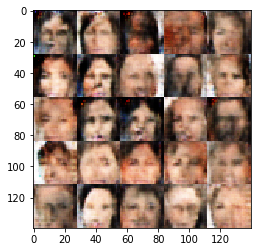

Epoch 1/1 steps 4710,  Discriminator Loss: 1.3845,  Generator Loss: 0.8081
Epoch 1/1 steps 4720,  Discriminator Loss: 1.3218,  Generator Loss: 0.9465
Epoch 1/1 steps 4730,  Discriminator Loss: 1.2342,  Generator Loss: 0.7785
Epoch 1/1 steps 4740,  Discriminator Loss: 1.3741,  Generator Loss: 0.8777
Epoch 1/1 steps 4750,  Discriminator Loss: 1.2460,  Generator Loss: 0.8319
Epoch 1/1 steps 4760,  Discriminator Loss: 1.3632,  Generator Loss: 0.8134
Epoch 1/1 steps 4770,  Discriminator Loss: 1.3212,  Generator Loss: 0.8988
Epoch 1/1 steps 4780,  Discriminator Loss: 1.3177,  Generator Loss: 0.8794
Epoch 1/1 steps 4790,  Discriminator Loss: 1.3997,  Generator Loss: 0.8770
Epoch 1/1 steps 4800,  Discriminator Loss: 1.3299,  Generator Loss: 0.9160


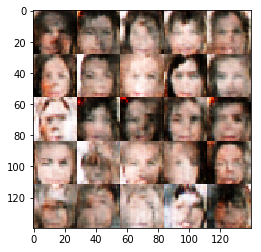

Epoch 1/1 steps 4810,  Discriminator Loss: 1.2925,  Generator Loss: 0.9123
Epoch 1/1 steps 4820,  Discriminator Loss: 1.3256,  Generator Loss: 0.8199
Epoch 1/1 steps 4830,  Discriminator Loss: 1.2780,  Generator Loss: 0.8840
Epoch 1/1 steps 4840,  Discriminator Loss: 1.3444,  Generator Loss: 0.8602
Epoch 1/1 steps 4850,  Discriminator Loss: 1.4248,  Generator Loss: 0.7022
Epoch 1/1 steps 4860,  Discriminator Loss: 1.3189,  Generator Loss: 0.8218
Epoch 1/1 steps 4870,  Discriminator Loss: 1.3515,  Generator Loss: 0.8717
Epoch 1/1 steps 4880,  Discriminator Loss: 1.3172,  Generator Loss: 0.9090
Epoch 1/1 steps 4890,  Discriminator Loss: 1.3477,  Generator Loss: 0.8907
Epoch 1/1 steps 4900,  Discriminator Loss: 1.3646,  Generator Loss: 0.9078


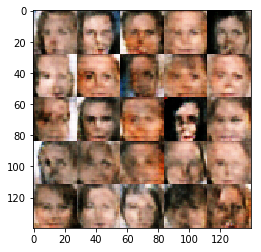

Epoch 1/1 steps 4910,  Discriminator Loss: 1.3640,  Generator Loss: 0.7959
Epoch 1/1 steps 4920,  Discriminator Loss: 1.4478,  Generator Loss: 0.7976
Epoch 1/1 steps 4930,  Discriminator Loss: 1.2627,  Generator Loss: 0.8297
Epoch 1/1 steps 4940,  Discriminator Loss: 1.2932,  Generator Loss: 0.7794
Epoch 1/1 steps 4950,  Discriminator Loss: 1.3538,  Generator Loss: 0.8643
Epoch 1/1 steps 4960,  Discriminator Loss: 1.4206,  Generator Loss: 0.8521
Epoch 1/1 steps 4970,  Discriminator Loss: 1.4531,  Generator Loss: 0.7898
Epoch 1/1 steps 4980,  Discriminator Loss: 1.3734,  Generator Loss: 0.8497
Epoch 1/1 steps 4990,  Discriminator Loss: 1.3768,  Generator Loss: 0.8290
Epoch 1/1 steps 5000,  Discriminator Loss: 1.3960,  Generator Loss: 0.8242


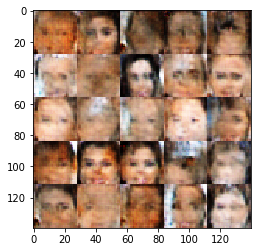

Epoch 1/1 steps 5010,  Discriminator Loss: 1.4382,  Generator Loss: 0.7907
Epoch 1/1 steps 5020,  Discriminator Loss: 1.3307,  Generator Loss: 0.8822
Epoch 1/1 steps 5030,  Discriminator Loss: 1.3096,  Generator Loss: 0.8485
Epoch 1/1 steps 5040,  Discriminator Loss: 1.2358,  Generator Loss: 0.9282
Epoch 1/1 steps 5050,  Discriminator Loss: 1.3230,  Generator Loss: 0.8880
Epoch 1/1 steps 5060,  Discriminator Loss: 1.3604,  Generator Loss: 0.8474
Epoch 1/1 steps 5070,  Discriminator Loss: 1.3237,  Generator Loss: 0.8528
Epoch 1/1 steps 5080,  Discriminator Loss: 1.3996,  Generator Loss: 0.8445
Epoch 1/1 steps 5090,  Discriminator Loss: 1.4015,  Generator Loss: 0.8041
Epoch 1/1 steps 5100,  Discriminator Loss: 1.3777,  Generator Loss: 0.8941


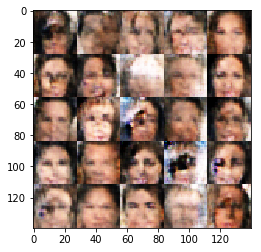

Epoch 1/1 steps 5110,  Discriminator Loss: 1.3716,  Generator Loss: 0.8632
Epoch 1/1 steps 5120,  Discriminator Loss: 1.3503,  Generator Loss: 0.7986
Epoch 1/1 steps 5130,  Discriminator Loss: 1.3974,  Generator Loss: 0.8134
Epoch 1/1 steps 5140,  Discriminator Loss: 1.3354,  Generator Loss: 0.9191
Epoch 1/1 steps 5150,  Discriminator Loss: 1.3368,  Generator Loss: 0.8330
Epoch 1/1 steps 5160,  Discriminator Loss: 1.3447,  Generator Loss: 0.8857
Epoch 1/1 steps 5170,  Discriminator Loss: 1.3352,  Generator Loss: 0.8590
Epoch 1/1 steps 5180,  Discriminator Loss: 1.3687,  Generator Loss: 0.8413
Epoch 1/1 steps 5190,  Discriminator Loss: 1.3836,  Generator Loss: 0.8168
Epoch 1/1 steps 5200,  Discriminator Loss: 1.2894,  Generator Loss: 0.8606


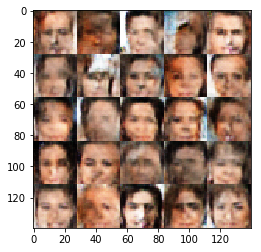

Epoch 1/1 steps 5210,  Discriminator Loss: 1.3132,  Generator Loss: 0.7970
Epoch 1/1 steps 5220,  Discriminator Loss: 1.3592,  Generator Loss: 0.8272
Epoch 1/1 steps 5230,  Discriminator Loss: 1.3516,  Generator Loss: 0.8430
Epoch 1/1 steps 5240,  Discriminator Loss: 1.4033,  Generator Loss: 0.7645
Epoch 1/1 steps 5250,  Discriminator Loss: 1.3745,  Generator Loss: 0.8578
Epoch 1/1 steps 5260,  Discriminator Loss: 1.4286,  Generator Loss: 0.8294
Epoch 1/1 steps 5270,  Discriminator Loss: 1.2339,  Generator Loss: 0.8341
Epoch 1/1 steps 5280,  Discriminator Loss: 1.4045,  Generator Loss: 0.8874
Epoch 1/1 steps 5290,  Discriminator Loss: 1.4278,  Generator Loss: 0.8254
Epoch 1/1 steps 5300,  Discriminator Loss: 1.2856,  Generator Loss: 0.8739


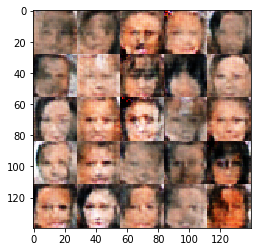

Epoch 1/1 steps 5310,  Discriminator Loss: 1.4428,  Generator Loss: 0.8142
Epoch 1/1 steps 5320,  Discriminator Loss: 1.2090,  Generator Loss: 0.9114
Epoch 1/1 steps 5330,  Discriminator Loss: 1.2626,  Generator Loss: 0.8092
Epoch 1/1 steps 5340,  Discriminator Loss: 1.3839,  Generator Loss: 0.8514
Epoch 1/1 steps 5350,  Discriminator Loss: 1.3270,  Generator Loss: 0.8337
Epoch 1/1 steps 5360,  Discriminator Loss: 1.4363,  Generator Loss: 0.8694
Epoch 1/1 steps 5370,  Discriminator Loss: 1.2811,  Generator Loss: 0.8819
Epoch 1/1 steps 5380,  Discriminator Loss: 1.4218,  Generator Loss: 0.7849
Epoch 1/1 steps 5390,  Discriminator Loss: 1.3654,  Generator Loss: 0.8049
Epoch 1/1 steps 5400,  Discriminator Loss: 1.3754,  Generator Loss: 0.8466


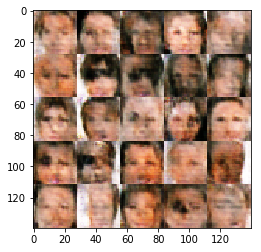

Epoch 1/1 steps 5410,  Discriminator Loss: 1.3917,  Generator Loss: 0.8872
Epoch 1/1 steps 5420,  Discriminator Loss: 1.2594,  Generator Loss: 0.8294
Epoch 1/1 steps 5430,  Discriminator Loss: 1.4168,  Generator Loss: 0.8434
Epoch 1/1 steps 5440,  Discriminator Loss: 1.4472,  Generator Loss: 0.8046
Epoch 1/1 steps 5450,  Discriminator Loss: 1.3435,  Generator Loss: 0.7695
Epoch 1/1 steps 5460,  Discriminator Loss: 1.4085,  Generator Loss: 0.8513
Epoch 1/1 steps 5470,  Discriminator Loss: 1.3263,  Generator Loss: 0.7876
Epoch 1/1 steps 5480,  Discriminator Loss: 1.3018,  Generator Loss: 0.9458
Epoch 1/1 steps 5490,  Discriminator Loss: 1.3812,  Generator Loss: 0.8852
Epoch 1/1 steps 5500,  Discriminator Loss: 1.3663,  Generator Loss: 0.7621


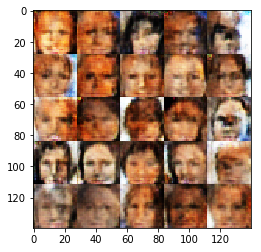

Epoch 1/1 steps 5510,  Discriminator Loss: 1.3182,  Generator Loss: 0.9142
Epoch 1/1 steps 5520,  Discriminator Loss: 1.3823,  Generator Loss: 0.8777
Epoch 1/1 steps 5530,  Discriminator Loss: 1.3556,  Generator Loss: 0.8372
Epoch 1/1 steps 5540,  Discriminator Loss: 1.3577,  Generator Loss: 0.8663
Epoch 1/1 steps 5550,  Discriminator Loss: 1.3194,  Generator Loss: 0.8742
Epoch 1/1 steps 5560,  Discriminator Loss: 1.3312,  Generator Loss: 0.7943
Epoch 1/1 steps 5570,  Discriminator Loss: 1.3314,  Generator Loss: 0.8257
Epoch 1/1 steps 5580,  Discriminator Loss: 1.3219,  Generator Loss: 0.8181
Epoch 1/1 steps 5590,  Discriminator Loss: 1.4160,  Generator Loss: 0.7981
Epoch 1/1 steps 5600,  Discriminator Loss: 1.3803,  Generator Loss: 0.7278


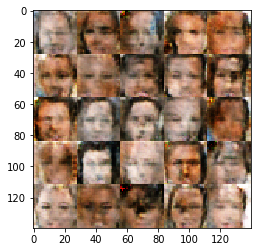

Epoch 1/1 steps 5610,  Discriminator Loss: 1.3724,  Generator Loss: 0.9268
Epoch 1/1 steps 5620,  Discriminator Loss: 1.4227,  Generator Loss: 0.8075
Epoch 1/1 steps 5630,  Discriminator Loss: 1.3869,  Generator Loss: 0.8668
Epoch 1/1 steps 5640,  Discriminator Loss: 1.3595,  Generator Loss: 0.8152
Epoch 1/1 steps 5650,  Discriminator Loss: 1.3638,  Generator Loss: 0.8444
Epoch 1/1 steps 5660,  Discriminator Loss: 1.3699,  Generator Loss: 0.7440
Epoch 1/1 steps 5670,  Discriminator Loss: 1.3745,  Generator Loss: 0.8518
Epoch 1/1 steps 5680,  Discriminator Loss: 1.3649,  Generator Loss: 0.8252
Epoch 1/1 steps 5690,  Discriminator Loss: 1.2779,  Generator Loss: 0.9196
Epoch 1/1 steps 5700,  Discriminator Loss: 1.3896,  Generator Loss: 0.9310


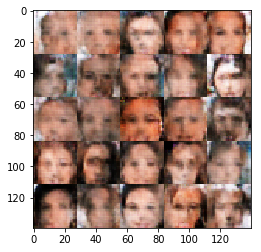

Epoch 1/1 steps 5710,  Discriminator Loss: 1.3755,  Generator Loss: 0.7649
Epoch 1/1 steps 5720,  Discriminator Loss: 1.3002,  Generator Loss: 0.8336
Epoch 1/1 steps 5730,  Discriminator Loss: 1.4216,  Generator Loss: 0.7935
Epoch 1/1 steps 5740,  Discriminator Loss: 1.3657,  Generator Loss: 0.8200
Epoch 1/1 steps 5750,  Discriminator Loss: 1.3799,  Generator Loss: 0.8264
Epoch 1/1 steps 5760,  Discriminator Loss: 1.3229,  Generator Loss: 0.8516
Epoch 1/1 steps 5770,  Discriminator Loss: 1.4113,  Generator Loss: 0.7747
Epoch 1/1 steps 5780,  Discriminator Loss: 1.3313,  Generator Loss: 0.8187
Epoch 1/1 steps 5790,  Discriminator Loss: 1.3395,  Generator Loss: 0.8561
Epoch 1/1 steps 5800,  Discriminator Loss: 1.3457,  Generator Loss: 0.7834


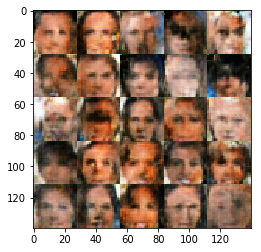

Epoch 1/1 steps 5810,  Discriminator Loss: 1.2462,  Generator Loss: 0.9011
Epoch 1/1 steps 5820,  Discriminator Loss: 1.3303,  Generator Loss: 0.8267
Epoch 1/1 steps 5830,  Discriminator Loss: 1.3828,  Generator Loss: 0.8185
Epoch 1/1 steps 5840,  Discriminator Loss: 1.2420,  Generator Loss: 0.8673
Epoch 1/1 steps 5850,  Discriminator Loss: 1.3636,  Generator Loss: 0.8911
Epoch 1/1 steps 5860,  Discriminator Loss: 1.3675,  Generator Loss: 0.7960
Epoch 1/1 steps 5870,  Discriminator Loss: 1.3614,  Generator Loss: 0.8206
Epoch 1/1 steps 5880,  Discriminator Loss: 1.3434,  Generator Loss: 0.8327
Epoch 1/1 steps 5890,  Discriminator Loss: 1.3422,  Generator Loss: 0.9106
Epoch 1/1 steps 5900,  Discriminator Loss: 1.3648,  Generator Loss: 0.7692


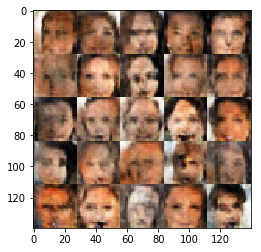

Epoch 1/1 steps 5910,  Discriminator Loss: 1.3595,  Generator Loss: 0.8234
Epoch 1/1 steps 5920,  Discriminator Loss: 1.2864,  Generator Loss: 0.8665
Epoch 1/1 steps 5930,  Discriminator Loss: 1.4392,  Generator Loss: 0.7711
Epoch 1/1 steps 5940,  Discriminator Loss: 1.3067,  Generator Loss: 0.8295
Epoch 1/1 steps 5950,  Discriminator Loss: 1.3701,  Generator Loss: 0.7938
Epoch 1/1 steps 5960,  Discriminator Loss: 1.3675,  Generator Loss: 0.7736
Epoch 1/1 steps 5970,  Discriminator Loss: 1.3921,  Generator Loss: 0.7739
Epoch 1/1 steps 5980,  Discriminator Loss: 1.2926,  Generator Loss: 0.9097
Epoch 1/1 steps 5990,  Discriminator Loss: 1.3607,  Generator Loss: 0.8448
Epoch 1/1 steps 6000,  Discriminator Loss: 1.3559,  Generator Loss: 0.8308


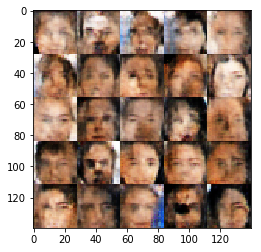

Epoch 1/1 steps 6010,  Discriminator Loss: 1.3102,  Generator Loss: 0.8005
Epoch 1/1 steps 6020,  Discriminator Loss: 1.3113,  Generator Loss: 0.9153
Epoch 1/1 steps 6030,  Discriminator Loss: 1.2752,  Generator Loss: 0.9116
Epoch 1/1 steps 6040,  Discriminator Loss: 1.3452,  Generator Loss: 0.8639
Epoch 1/1 steps 6050,  Discriminator Loss: 1.3642,  Generator Loss: 0.8793
Epoch 1/1 steps 6060,  Discriminator Loss: 1.2661,  Generator Loss: 0.8629
Epoch 1/1 steps 6070,  Discriminator Loss: 1.3445,  Generator Loss: 0.8196
Epoch 1/1 steps 6080,  Discriminator Loss: 1.3473,  Generator Loss: 0.9084
Epoch 1/1 steps 6090,  Discriminator Loss: 1.2863,  Generator Loss: 0.8234
Epoch 1/1 steps 6100,  Discriminator Loss: 1.2487,  Generator Loss: 0.8955


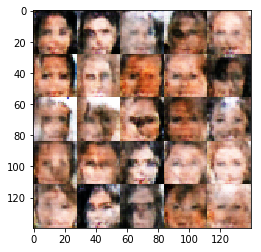

Epoch 1/1 steps 6110,  Discriminator Loss: 1.4362,  Generator Loss: 0.7694
Epoch 1/1 steps 6120,  Discriminator Loss: 1.3753,  Generator Loss: 0.8518
Epoch 1/1 steps 6130,  Discriminator Loss: 1.3407,  Generator Loss: 0.8066
Epoch 1/1 steps 6140,  Discriminator Loss: 1.3567,  Generator Loss: 0.8089
Epoch 1/1 steps 6150,  Discriminator Loss: 1.3178,  Generator Loss: 0.8429
Epoch 1/1 steps 6160,  Discriminator Loss: 1.2837,  Generator Loss: 0.8679
Epoch 1/1 steps 6170,  Discriminator Loss: 1.3241,  Generator Loss: 0.8203
Epoch 1/1 steps 6180,  Discriminator Loss: 1.3469,  Generator Loss: 0.8410
Epoch 1/1 steps 6190,  Discriminator Loss: 1.4070,  Generator Loss: 0.8189
Epoch 1/1 steps 6200,  Discriminator Loss: 1.3711,  Generator Loss: 0.8508


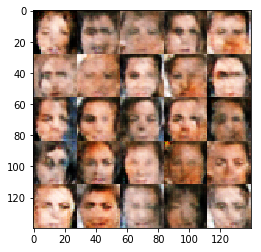

Epoch 1/1 steps 6210,  Discriminator Loss: 1.3767,  Generator Loss: 0.8796
Epoch 1/1 steps 6220,  Discriminator Loss: 1.4204,  Generator Loss: 0.7955
Epoch 1/1 steps 6230,  Discriminator Loss: 1.3204,  Generator Loss: 0.8377
Epoch 1/1 steps 6240,  Discriminator Loss: 1.3694,  Generator Loss: 0.8520
Epoch 1/1 steps 6250,  Discriminator Loss: 1.3982,  Generator Loss: 0.7831
Epoch 1/1 steps 6260,  Discriminator Loss: 1.3951,  Generator Loss: 0.8026
Epoch 1/1 steps 6270,  Discriminator Loss: 1.2958,  Generator Loss: 0.8720
Epoch 1/1 steps 6280,  Discriminator Loss: 1.3291,  Generator Loss: 0.7789
Epoch 1/1 steps 6290,  Discriminator Loss: 1.2892,  Generator Loss: 0.8558
Epoch 1/1 steps 6300,  Discriminator Loss: 1.4567,  Generator Loss: 0.8821


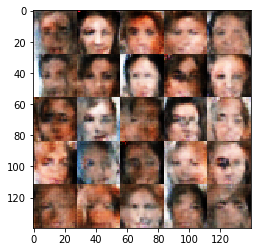

Epoch 1/1 steps 6310,  Discriminator Loss: 1.3658,  Generator Loss: 0.8458
Epoch 1/1 steps 6320,  Discriminator Loss: 1.2996,  Generator Loss: 0.8142
Epoch 1/1 steps 6330,  Discriminator Loss: 1.3768,  Generator Loss: 0.8695
Final Plot


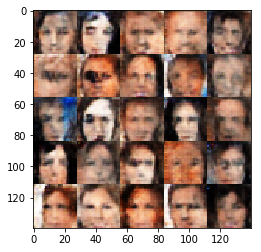

In [59]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.